In [1]:
import pandas as pd
import numpy as np
import sqlite3
import yfinance as yf
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm

from causallearn.search.FCMBased import lingam
from sklearn.linear_model import LinearRegression
from causallearn.search.FCMBased.lingam.utils import make_dot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

# To Do!
The main goal of the next push is to get some causal discovery working.

* [ ] **Input Fetching Revamp**
    * [X] Finish `wbdata` module
    * [ ] Fetching more tickers from `yfinance`
    * [ ] Systematic loading and preparation of all tickers
    * [ ] Fetcher should not `dropna()` - that should happen in the loader
    * [ ] OOP?
* [X] **Causal Discovery**

# Global Variables

In [2]:
start_date = "2000-01-01"
end_date = "2022-12-31"
#tickers = [ "AAPL", "MSFT", "^GSPC", "GPW.WA", "MBK.WA", "ALE.WA" ]

# Input Fetching

In [3]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

In [7]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []

for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]

In [9]:
prices = (yf.download(
    tickers=tickers,
    start=start_date, 
    end=end_date, 
    progress=False,
    group_by='ticker',
    period='1d'
  )
  .rename(columns={
    "Date": "date", 
    "Open": "open", 
    "High": "high",
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
)

l = [];
for ticker in tickers:
    l.append(prices[ticker].reset_index().assign(ticker=ticker))
merged = pd.concat(l).dropna()
del l

tidy_finance = sqlite3.connect(database="tidy_finance_python.sqlite")
merged.to_sql(name = "prices", con=tidy_finance, if_exists="replace", index=False)


6 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['VLTO', 'SOLV', 'KVUE', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1672462800")
['BF.B']: Exception("%ticker%: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")


2551230

## World Bank Data

In [4]:
import wbdata

In [5]:
wbdata.get_sources()
# 2  World Development Indicators
# 25  Jobs
# 38  Subnational Poverty
# 50  Subnational Population
# 88  Food Prices for Nutrition
# 61 PPPs Regulatory Quality
# 58  Universal Health Coverage

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

In [5]:
gdp_indicators = wbdata.get_indicators(query="(% of GDP)", source=2)
gdp_indicators

id                    name
--------------------  -------------------------------------------------------------------
BG.GSR.NFSV.GD.ZS     Trade in services (% of GDP)
BM.KLT.DINV.WD.GD.ZS  Foreign direct investment, net outflows (% of GDP)
BN.CAB.XOKA.GD.ZS     Current account balance (% of GDP)
BX.KLT.DINV.WD.GD.ZS  Foreign direct investment, net inflows (% of GDP)
BX.TRF.PWKR.DT.GD.ZS  Personal remittances, received (% of GDP)
CM.MKT.LCAP.GD.ZS     Market capitalization of listed domestic companies (% of GDP)
CM.MKT.TRAD.GD.ZS     Stocks traded, total value (% of GDP)
FD.AST.PRVT.GD.ZS     Domestic credit to private sector by banks (% of GDP)
FM.LBL.BMNY.GD.ZS     Broad money (% of GDP)
FS.AST.DOMO.GD.ZS     Claims on other sectors of the domestic economy (% of GDP)
FS.AST.DOMS.GD.ZS     Domestic credit provided by financial sector (% of GDP)
FS.AST.PRVT.GD.ZS     Domestic credit to private sector (% of GDP)
GB.XPD.RSDV.GD.ZS     Research and development expenditure (% of GDP)
GC.AS

In [6]:
gdp_indicator_ids = [ 
    'NE.CON.GOVT.ZS',   # 'General government final consumption expenditure (% of GDP)'
    'NE.CON.PRVT.ZS',   # 'Households and NPISHs final consumption expenditure (% of GDP)'
    'NE.EXP.GNFS.ZS',   # 'Exports of goods and services (% of GDP)'
    'NE.GDI.TOTL.ZS',   # 'Gross capital formation (% of GDP)'
    'NE.IMP.GNFS.ZS'    # 'Imports of goods and services (% of GDP)'
];
gdp_indicators = wbdata.get_indicators(source=2)
gdp_indicators = list(filter(lambda elem: elem[ 'id' ] in gdp_indicator_ids, gdp_indicators))
gdp_indicators

[{'id': 'NE.CON.GOVT.ZS',
  'name': 'General government final consumption expenditure (% of GDP)',
  'unit': '',
  'source': {'id': '2', 'value': 'World Development Indicators'},
  'sourceNote': 'General government final consumption expenditure (formerly general government consumption) includes all government current expenditures for purchases of goods and services (including compensation of employees). It also includes most expenditures on national defense and security, but excludes government military expenditures that are part of government capital formation.',
  'sourceOrganization': 'World Bank national accounts data, and OECD National Accounts data files.',
  'topics': [{'id': '3', 'value': 'Economy & Growth'}]},
 {'id': 'NE.CON.PRVT.ZS',
  'name': 'Households and NPISHs final consumption expenditure (% of GDP)',
  'unit': '',
  'source': {'id': '2', 'value': 'World Development Indicators'},
  'sourceNote': 'Household final consumption expenditure (formerly private consumption) i

In [7]:
gdp_indicators_temp = dict()
for indicator in gdp_indicators:
    gdp_indicators_temp[ indicator[ 'id' ] ] = indicator[ 'name' ]
gdp_indicators = gdp_indicators_temp
gdp_indicators

{'NE.CON.GOVT.ZS': 'General government final consumption expenditure (% of GDP)',
 'NE.CON.PRVT.ZS': 'Households and NPISHs final consumption expenditure (% of GDP)',
 'NE.EXP.GNFS.ZS': 'Exports of goods and services (% of GDP)',
 'NE.GDI.TOTL.ZS': 'Gross capital formation (% of GDP)',
 'NE.IMP.GNFS.ZS': 'Imports of goods and services (% of GDP)'}

In [8]:
all_income_levels = wbdata.get_incomelevels(level_id=None) 
all_income_levels

id    value
----  -------------------
HIC   High income
INX   Not classified
LIC   Low income
LMC   Lower middle income
LMY   Low & middle income
MIC   Middle income
UMC   Upper middle income

In [9]:
country_ids_by_income = dict()
country_names_by_income = dict()
for income_level in all_income_levels:
    income_id = income_level[ 'id' ]
    country_ids_by_income[ income_id ]      = [e[ 'id' ]    for e in wbdata.get_countries(incomelevel=income_id)]
    country_names_by_income[ income_id ]    = [e[ 'name' ]  for e in wbdata.get_countries(incomelevel=income_id)]

In [10]:
list(enumerate(country_names_by_income['HIC']))

[(0, 'Aruba'),
 (1, 'Andorra'),
 (2, 'United Arab Emirates'),
 (3, 'American Samoa'),
 (4, 'Antigua and Barbuda'),
 (5, 'Australia'),
 (6, 'Austria'),
 (7, 'Belgium'),
 (8, 'Bahrain'),
 (9, 'Bahamas, The'),
 (10, 'Bermuda'),
 (11, 'Barbados'),
 (12, 'Brunei Darussalam'),
 (13, 'Canada'),
 (14, 'Switzerland'),
 (15, 'Channel Islands'),
 (16, 'Chile'),
 (17, 'Curacao'),
 (18, 'Cayman Islands'),
 (19, 'Cyprus'),
 (20, 'Czechia'),
 (21, 'Germany'),
 (22, 'Denmark'),
 (23, 'Spain'),
 (24, 'Estonia'),
 (25, 'Finland'),
 (26, 'France'),
 (27, 'Faroe Islands'),
 (28, 'United Kingdom'),
 (29, 'Gibraltar'),
 (30, 'Greece'),
 (31, 'Greenland'),
 (32, 'Guam'),
 (33, 'Guyana'),
 (34, 'Hong Kong SAR, China'),
 (35, 'Croatia'),
 (36, 'Hungary'),
 (37, 'Isle of Man'),
 (38, 'Ireland'),
 (39, 'Iceland'),
 (40, 'Israel'),
 (41, 'Italy'),
 (42, 'Japan'),
 (43, 'St. Kitts and Nevis'),
 (44, 'Korea, Rep.'),
 (45, 'Kuwait'),
 (46, 'Liechtenstein'),
 (47, 'Lithuania'),
 (48, 'Luxembourg'),
 (49, 'Latvia'),
 

In [11]:
# HACK
countries = country_ids_by_income[ 'HIC' ][2] 
countries

'ARE'

In [12]:
df = wbdata.get_dataframe(gdp_indicators, country=country_ids_by_income[ 'HIC' ], parse_dates=True, keep_levels=True).dropna()
df[ 'Imports of goods and services (% of GDP)' ] = df['Imports of goods and services (% of GDP)'].apply(lambda x: x*-1)
df.loc[:, 'Total'] = df.sum(axis=1)
df

General government final consumption expenditure (% of GDP)  \
country       date                                                                      
Aruba         2022-01-01                                          19.903168             
              2021-01-01                                          21.848676             
              2020-01-01                                          27.466134             
              2019-01-01                                          22.498552             
              2018-01-01                                          23.071020             
...                                                                     ...             
United States 1974-01-01                                          17.162673             
              1973-01-01                                          16.776275             
              1972-01-01                                          17.629289             
              1971-01-01                                          17.938790             
              1970-01-01                                          17.961843             

                          Households and NPISHs final consumption expenditure (% of GDP)  \
country       date                                                                         
Aruba         2022-01-01                                          53.754376                
              2021-01-01                                          59.072629                
              2020-01-01                                          63.347345                
              2019-01-01                                          53.937333                
              2018-01-01                                          55.235260                
...                                                                     ...                
United States 1974-01-01                                          60.195128                
              1973-01-01                                          59.603571                
              1972-01-01                                          60.053709                
              1971-01-01                                          60.088166                
              1970-01-01                                          60.255492                

                          Exports of goods and services (% of GDP)  \
country       date                                                   
Aruba         2022-01-01                                 83.124605   
              2021-01-01                                 69.069709   
              2020-01-01                                 55.326811   
              2019-01-01                                 73.234592   
              2018-01-01                                 72.252774   
...                                                            ...   
United States 1974-01-01                                  8.196122   
              1973-01-01                                  6.683780   
              1972-01-01                                  5.538460   
              1971-01-01                                  5.405245   
              1970-01-01                                  5.563108   

                          Gross capital formation (% of GDP)  \
country       date                                             
Aruba         2022-01-01                           20.552502   
              2021-01-01                           20.839364   
              2020-01-01                           22.695274   
              2019-01-01                           22.438504   
              2018-01-01                           22.401724   
...                                                      ...   
United States 1974-01-01                           22.694942   
              1973-01-01                           23.331809   
              1972-01-01                           22.580622   
              1971-01-01                           21.91

<Axes: xlabel='country,date'>

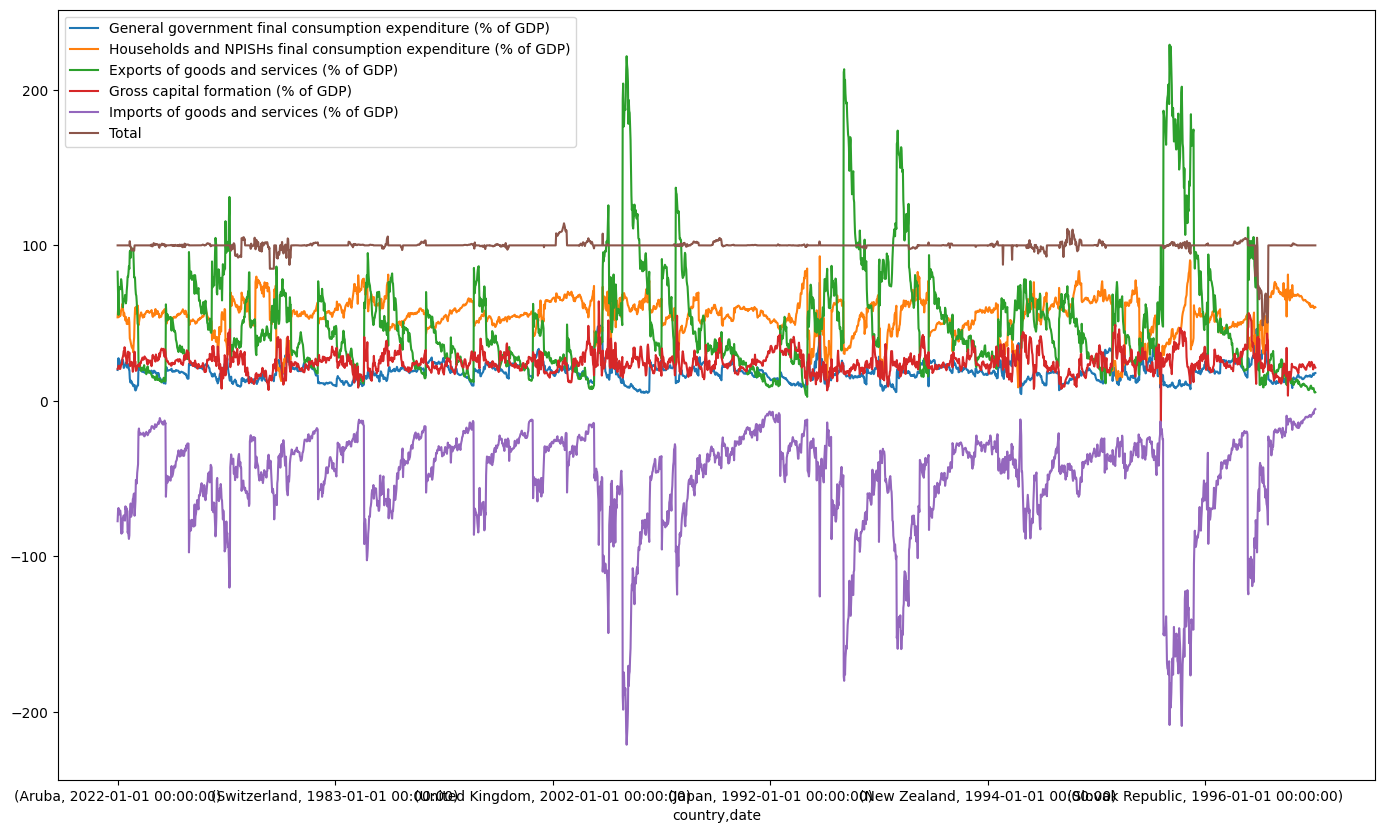

In [13]:
df.plot(figsize=(17,10))

# Testing Causal Discovery on wbdata

In [14]:
usa_macro = df.loc[pd.IndexSlice['United States', :]].drop('Total', axis=1)
for c in usa_macro.columns:
    # usa_macro[ c ] = np.log(usa_macro[ c ]) - np.log(usa_macro[ c ].shift(1))
    usa_macro[ c ] = usa_macro[ c ] / usa_macro[ c ].shift(1) - 1
usa_macro = usa_macro.fillna(0)
usa_macro.head()

,General government final consumption expenditure (% of GDP),Households and NPISHs final consumption expenditure (% of GDP),Exports of goods and services (% of GDP),Gross capital formation (% of GDP),Imports of goods and services (% of GDP)
date,,,,,
2022-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01,0.028837,-0.000391,-0.070995,-0.023222,-0.062353
2020-01-01,0.045232,-0.019691,-0.066567,0.002076,-0.098155
2019-01-01,-0.065622,-0.000334,0.162915,0.007138,0.105790
2018-01-01,-0.012302,0.006399,0.041147,-0.005991,0.046043


Index(['General government final consumption expenditure (% of GDP)',
       'Households and NPISHs final consumption expenditure (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)'],
      dtype='object')
[1, 0, 3, 4, 2]
[[ 0.          1.47247013  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [-1.32847961 -5.13789088  0.         -1.87795589  1.14826308]
 [-1.08927784 -2.2674777   0.          0.          0.        ]
 [ 0.          3.9500825   0.          1.29864168  0.        ]]


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


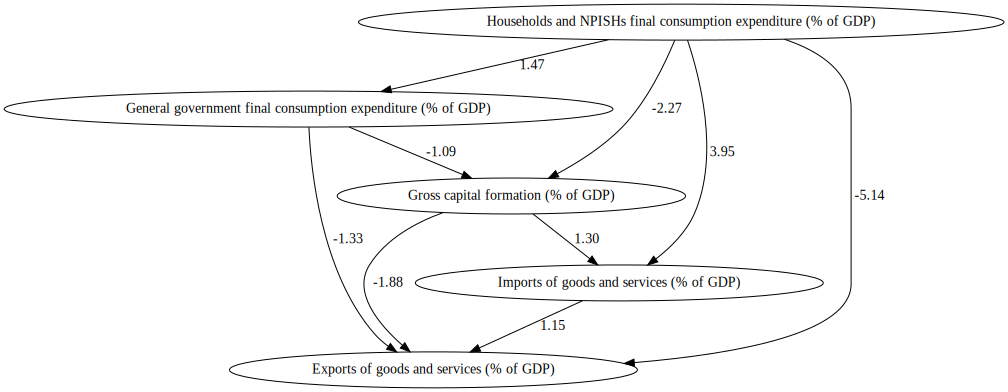

In [15]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM(random_state=123, max_iter=1000000)

model.fit(usa_macro)
print(usa_macro.columns)
print(model.causal_order_)
print(model.adjacency_matrix_)

from causallearn.search.FCMBased.lingam.utils import make_dot
graph_dot = make_dot(model.adjacency_matrix_, labels=[f'{col}' for i, col in enumerate(usa_macro.columns)])
graph_dot

In [16]:
from causallearn.score.LocalScoreFunction import local_score_BIC
#from causallearn.score.LocalScoreFunction import *
score = local_score_BIC(usa_macro, 1, [ 0, 2, 3, 4 ], None)
score

matrix([[-576.6194094]])

In [17]:
target = "Exports of goods and services (% of GDP)"
from statsmodels.tsa.stattools import adfuller
adfuller(usa_macro[target])

(-4.539566584669888,
 0.00016668330473380407,
 11,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 -107.80127168153098)

It's stationary

<Axes: xlabel='date'>

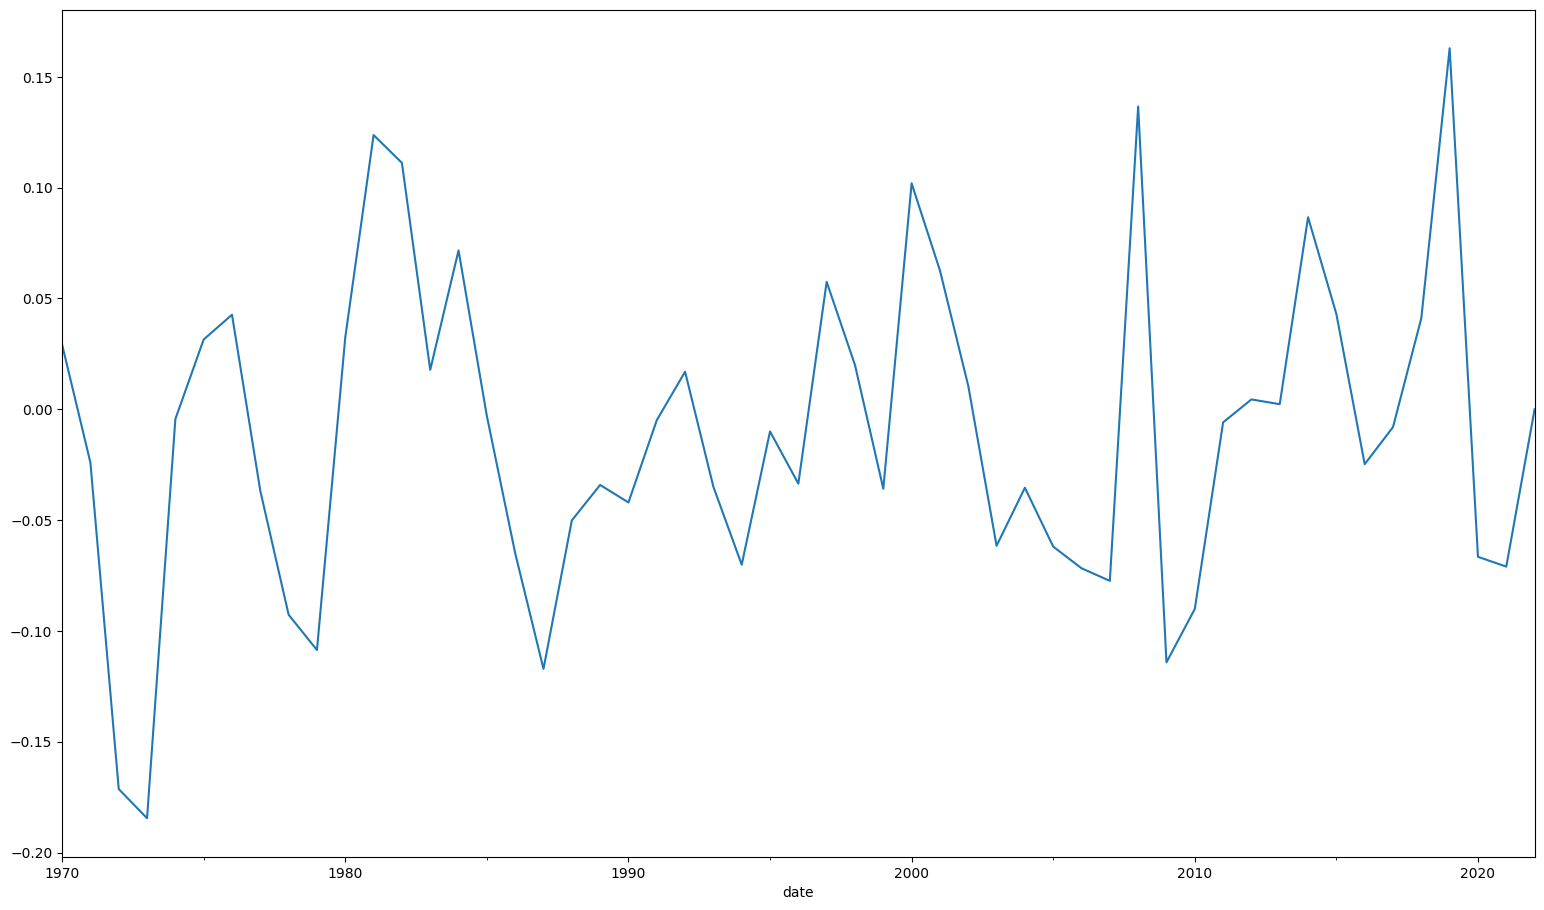

In [18]:
usa_macro[target].plot(figsize=(19,11))

<Axes: >

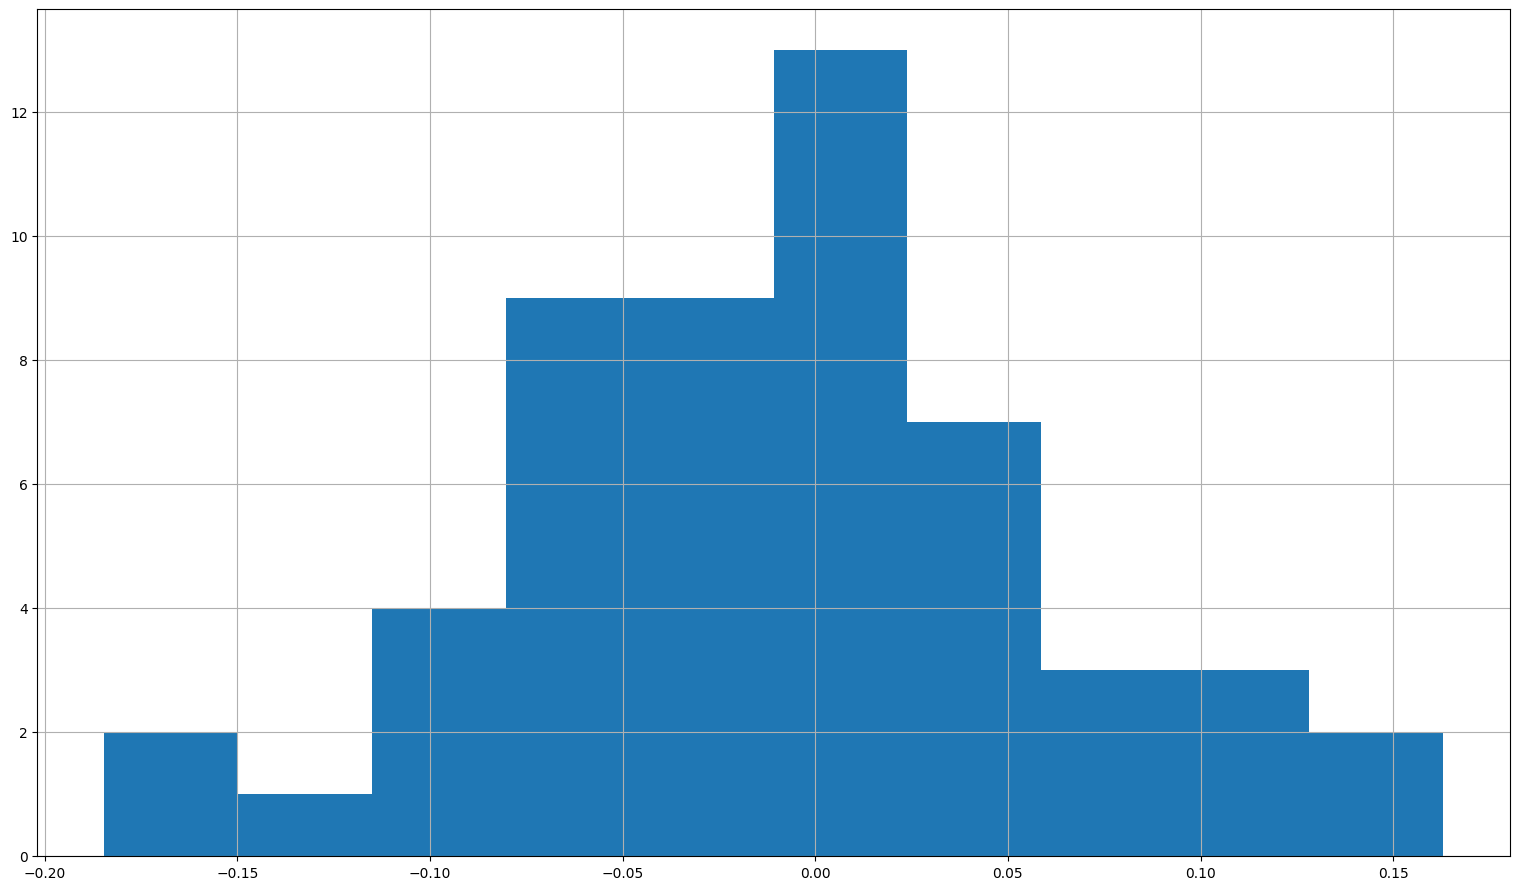

In [19]:
usa_macro[target].hist(figsize=(19,11))

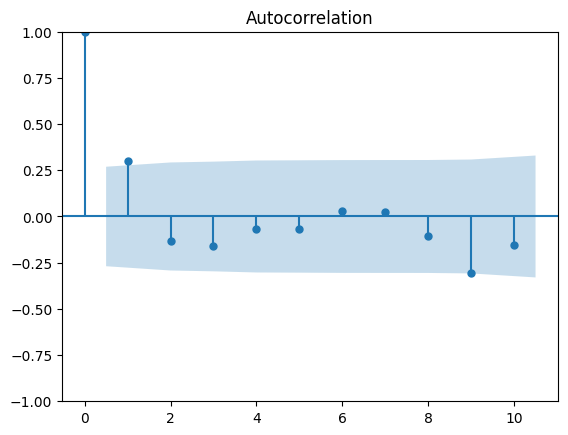

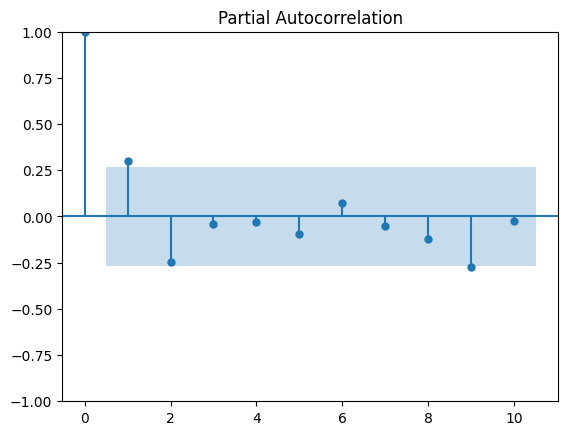

In [20]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(usa_macro[ target ].values.squeeze(), lags=10)
sm.graphics.tsa.plot_pacf(usa_macro[ target ].values.squeeze(), lags=10, method="ywm")
plt.show()

I think I need to remove the time dimention by using returns and assuming that the distribution of returns is time-independant.

In [27]:
zero_onto_two = model.estimate_total_effect(usa_macro, 0, 2)
zero_onto_two

-0.8988336101801498

In [36]:
import statsmodels.api as sm
lin_zero_two_model = sm.OLS(usa_macro[usa_macro.columns[ 2 ]], usa_macro[usa_macro.columns[ 0 ]]).fit()

#view model summary
print(lin_zero_two_model.summary())

                                            OLS Regression Results                                           
Dep. Variable:     Exports of goods and services (% of GDP)   R-squared (uncentered):                   0.130
Model:                                                  OLS   Adj. R-squared (uncentered):              0.113
Method:                                       Least Squares   F-statistic:                              7.766
Date:                                      Sat, 18 May 2024   Prob (F-statistic):                     0.00742
Time:                                              22:23:27   Log-Likelihood:                          67.266
No. Observations:                                        53   AIC:                                     -132.5
Df Residuals:                                            52   BIC:                                     -130.6
Df Model:                                                 1                                                  
Covariance

Index(['General government final consumption expenditure (% of GDP)',
       'Households and NPISHs final consumption expenditure (% of GDP)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)'],
      dtype='object')

In [70]:
predictors = usa_macro[df.columns[[0,1,3,4]]]
predictors.head()

,General government final consumption expenditure (% of GDP),Households and NPISHs final consumption expenditure (% of GDP),Gross capital formation (% of GDP),Imports of goods and services (% of GDP)
date,,,,
2022-01-01,0.000000,0.000000,0.000000,0.000000
2021-01-01,0.028837,-0.000391,-0.023222,-0.062353
2020-01-01,0.045232,-0.019691,0.002076,-0.098155
2019-01-01,-0.065622,-0.000334,0.007138,0.105790
2018-01-01,-0.012302,0.006399,-0.005991,0.046043


In [71]:
lin_zero_two_model_parents = sm.OLS(usa_macro[usa_macro.columns[ 2 ]], predictors).fit()

#view model summary
print(lin_zero_two_model_parents.summary())

                                            OLS Regression Results                                           
Dep. Variable:     Exports of goods and services (% of GDP)   R-squared (uncentered):                   0.881
Model:                                                  OLS   Adj. R-squared (uncentered):              0.872
Method:                                       Least Squares   F-statistic:                              90.89
Date:                                      Sat, 18 May 2024   Prob (F-statistic):                    4.84e-22
Time:                                              22:38:07   Log-Likelihood:                          120.04
No. Observations:                                        53   AIC:                                     -232.1
Df Residuals:                                            49   BIC:                                     -224.2
Df Model:                                                 4                                                  
Covariance

In [ ]:
, apple_close).fit()

#view model summary
print(model2.summary())

In [22]:
p_value_mat = np.around(np.matrix(model.get_error_independence_p_values(usa_macro)),decimals=3)
p_value_mat

array([[0.   , 0.542, 0.925, 0.459, 0.51 ],
       [0.542, 0.   , 0.018, 0.965, 0.14 ],
       [0.925, 0.018, 0.   , 0.   , 0.098],
       [0.459, 0.965, 0.   , 0.   , 0.681],
       [0.51 , 0.14 , 0.098, 0.681, 0.   ]])

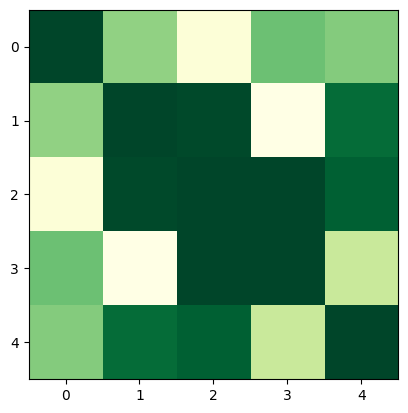

In [23]:
plt.imshow(p_value_mat, cmap='YlGn_r') # dark shows closer to 0, light closer to 1.  if p-value < 0.05 reject indep. -> dependent.
plt.show()

# Causal Analysis on Stocks

## Pulling Lots of Data

In [4]:
tidy_finance = sqlite3.connect(database="/wd/tidy_finance_python.sqlite")

raw_prices = pd.read_sql_query(
    sql = "SELECT date, ticker, close FROM prices",
    con = tidy_finance,
    parse_dates={"date"}
).set_index(['ticker', 'Date'])
raw_prices.head()

close
ticker Date                          
MMM    2000-01-03 00:00:00  39.454430
       2000-01-04 00:00:00  37.886707
       2000-01-05 00:00:00  38.984116
       2000-01-06 00:00:00  42.119564
       2000-01-07 00:00:00  42.955685

In [5]:
raw_prices[ 'simple_return' ] = ( raw_prices[ 'close' ] / raw_prices[ 'close' ].shift( 1 ) - 1 ).fillna( 0 )
raw_prices[ 'log_return' ] = ( np.log( raw_prices[ 'close' ] ) - np.log( raw_prices[ 'close' ].shift( 1 ) ) ).fillna( 0 )
raw_prices.head()

close  simple_return  log_return
ticker Date                                                     
MMM    2000-01-03 00:00:00  39.454430       0.000000    0.000000
       2000-01-04 00:00:00  37.886707      -0.039735   -0.040546
       2000-01-05 00:00:00  38.984116       0.028966    0.028554
       2000-01-06 00:00:00  42.119564       0.080429    0.077358
       2000-01-07 00:00:00  42.955685       0.019851    0.019657

In [6]:
def preprocess(df, column: str, new_index: str):
    return(df.groupby([ 'Date', 'ticker' ])[ column ].first().unstack().reset_index().rename_axis(None, axis=1).set_index( new_index ).ffill().fillna(0))

In [7]:
close_df = preprocess(raw_prices, 'close', 'Date')
simple_return_df = preprocess(raw_prices, 'simple_return', 'Date')
log_return_df = preprocess(raw_prices, 'log_return', 'Date')

simple_return_df.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00,-0.284096,0.0,-0.978590,0.0,0.0,-0.725515,-0.986280,0.0,-0.938575,-0.407752,...,0.0,0.987344,0.0,-0.769613,-0.733957,0.0,-0.939350,0.0,-0.804593,0.0
2000-01-04 00:00:00,-0.076389,0.0,-0.084310,0.0,0.0,-0.028571,-0.005435,0.0,-0.083889,-0.050589,...,0.0,-0.037567,0.0,0.023026,-0.019154,0.0,-0.020101,0.0,-0.014428,0.0
2000-01-05 00:00:00,-0.062030,0.0,0.014633,0.0,0.0,-0.001838,0.092897,0.0,0.019771,0.014599,...,0.0,0.052974,0.0,0.038585,0.054516,0.0,0.005128,0.0,0.019144,0.0
2000-01-06 00:00:00,-0.038076,0.0,-0.086538,0.0,0.0,0.034991,-0.010000,0.0,0.008163,-0.027338,...,0.0,0.046778,0.0,-0.009288,0.051698,0.0,-0.008503,0.0,-0.054144,0.0
2000-01-07 00:00:00,0.083333,0.0,0.047369,0.0,0.0,0.010676,0.055556,0.0,0.048583,0.028107,...,0.0,-0.032884,0.0,0.000000,-0.002935,0.0,-0.022298,0.0,-0.011098,0.0


<Axes: xlabel='Date'>

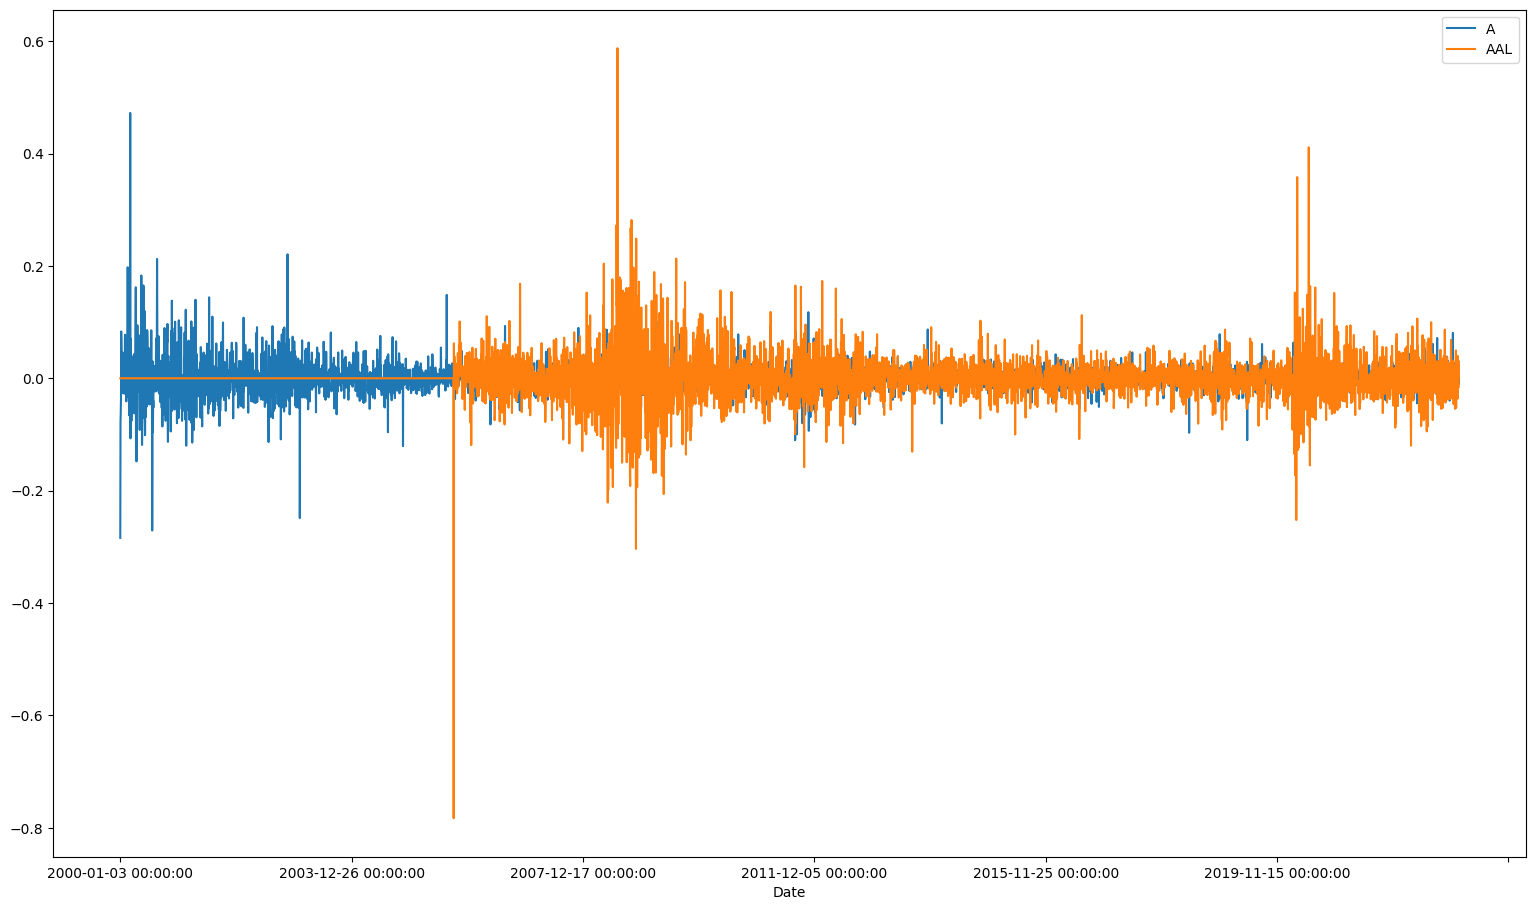

In [8]:
simple_return_df.iloc[:, [0, 1]].plot(figsize=(19,11))

<Axes: xlabel='Date'>

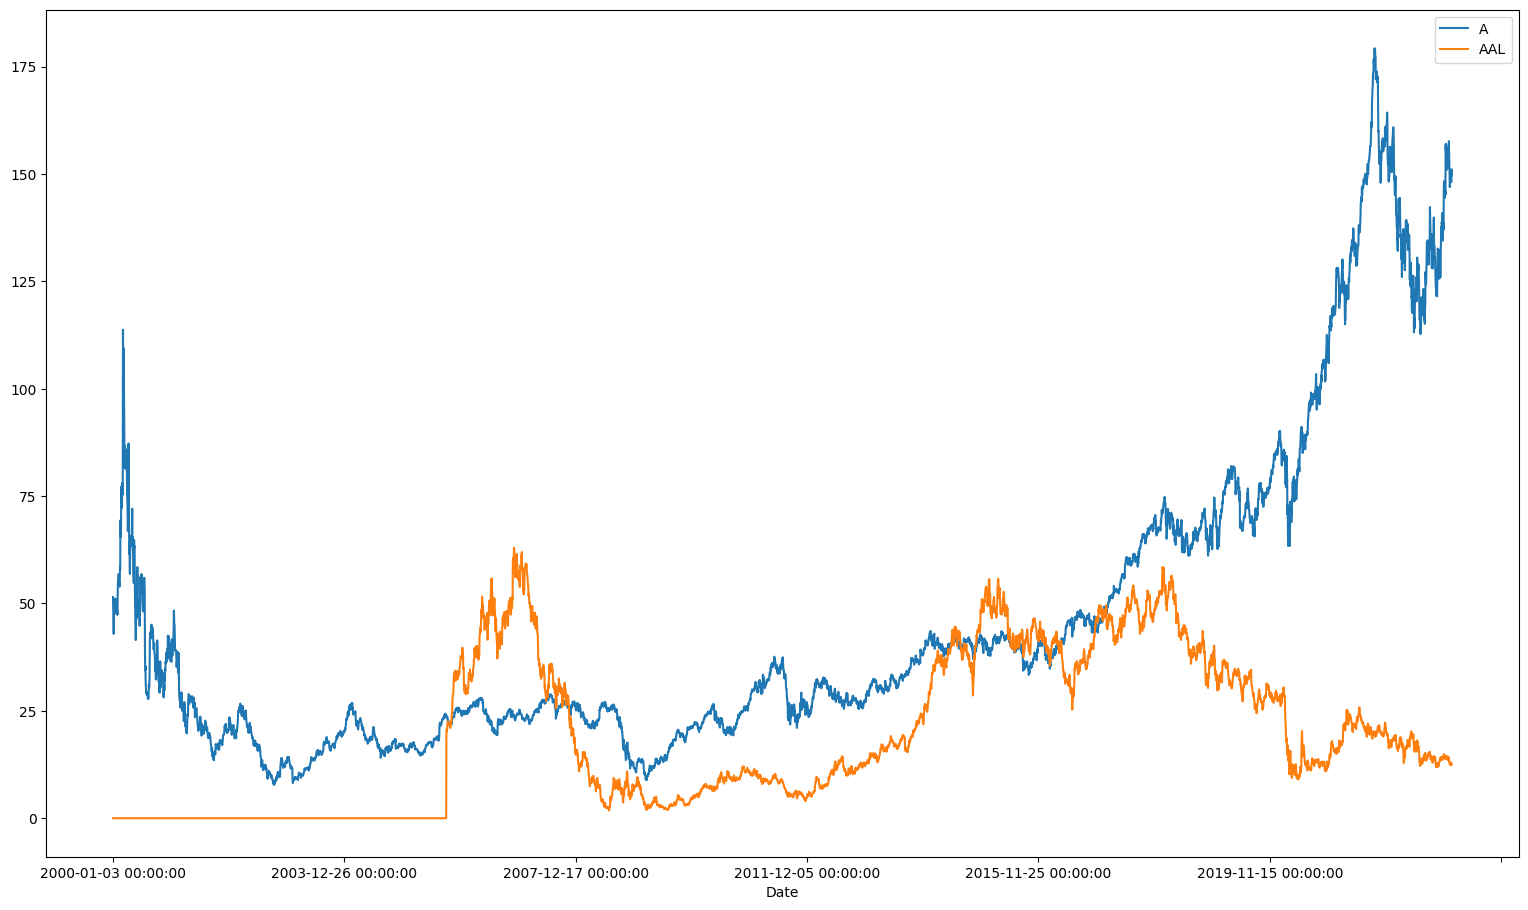

In [9]:
close_df.iloc[:, [0, 1]].plot(figsize=(19,11))

### Dimensionality Reduction -- PCA

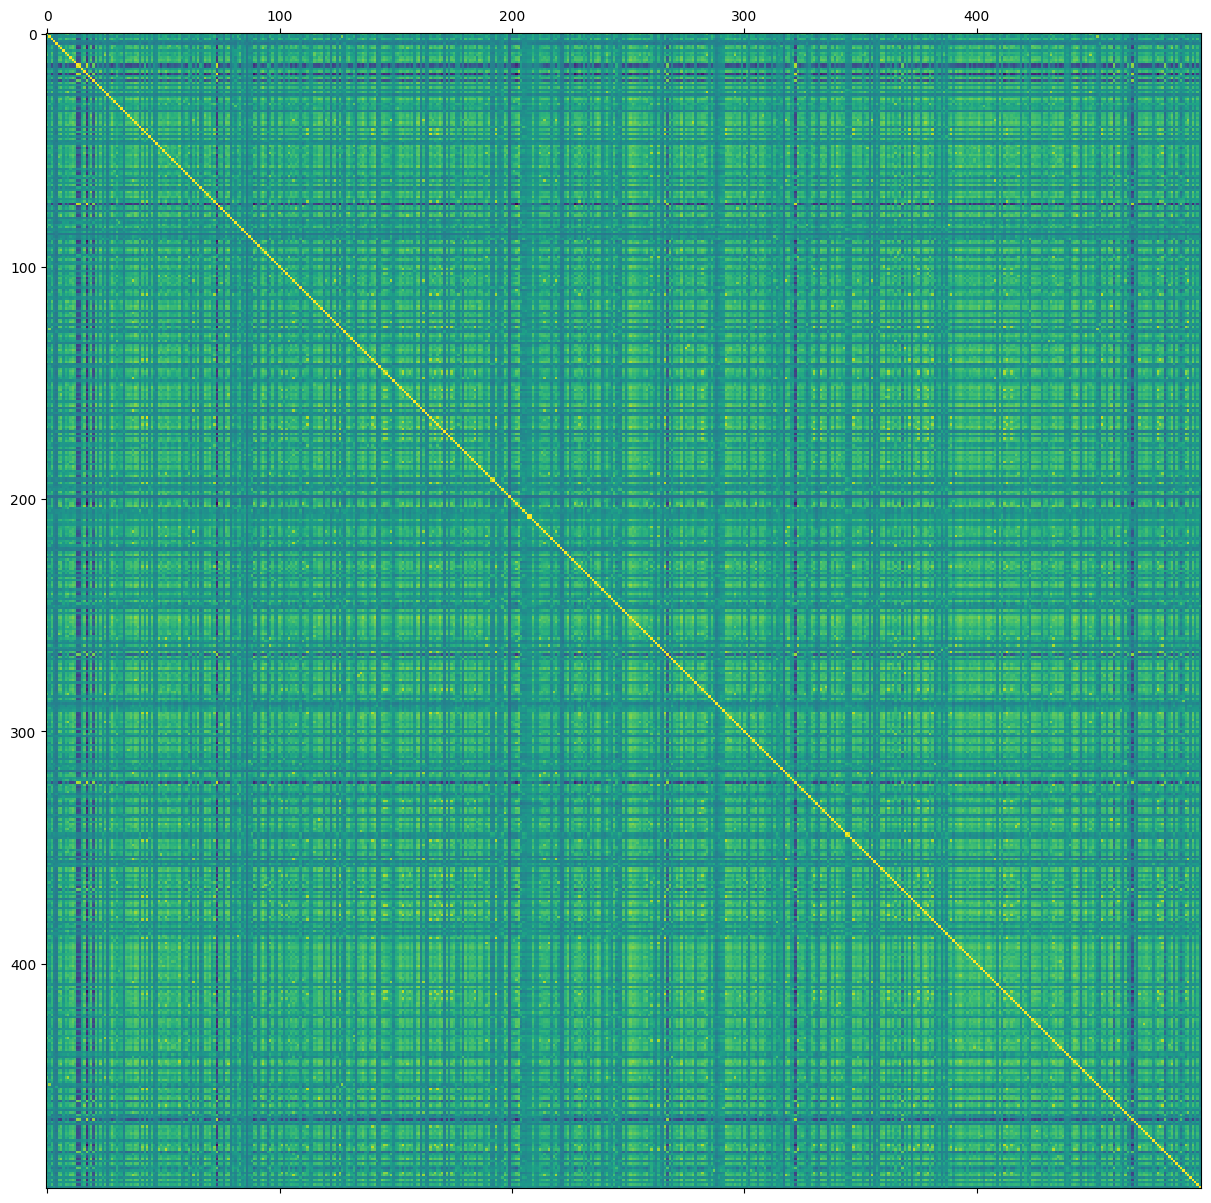

In [23]:
simple_return_corr = simple_return_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(simple_return_corr)

In [43]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [51]:
pca = PCA(n_components=40)
pca.fit(simple_return_df)

PCA(n_components=40)

In [42]:
len(pca.explained_variance_ratio_)

In [52]:
sum(pca.explained_variance_ratio_)

In [70]:
svd = TruncatedSVD(n_components=10, n_iter=700, random_state=42, n_oversamples=100)
svd.fit(simple_return_df)
sum(svd.explained_variance_ratio_)

In [71]:
svd_df = pd.DataFrame(svd.transform(simple_return_df), columns=svd.get_feature_names_out(), index=simple_return_df.index)
svd_df.head()

,truncatedsvd0,truncatedsvd1,truncatedsvd2,truncatedsvd3,truncatedsvd4,truncatedsvd5,truncatedsvd6,truncatedsvd7,truncatedsvd8,truncatedsvd9
Date,,,,,,,,,,
2000-01-03 00:00:00,15.830846,11.131741,0.028754,-0.026530,0.376439,-0.292976,-0.028356,0.004800,-0.151799,0.021529
2000-01-04 00:00:00,0.420735,-0.193315,0.199028,-0.093362,-0.074139,-0.067507,-0.127170,0.059149,0.006205,0.031291
2000-01-05 00:00:00,-0.108956,-0.016237,0.095839,-0.041766,0.128991,-0.121416,0.051621,0.056913,-0.074348,0.020403
2000-01-06 00:00:00,-0.127681,-0.052823,0.367627,-0.061582,0.074709,0.047330,0.045755,-0.089678,0.054566,-0.037888
2000-01-07 00:00:00,-0.413016,0.154145,-0.196501,0.100260,0.213990,-0.014232,0.116398,-0.074180,0.086887,0.204455


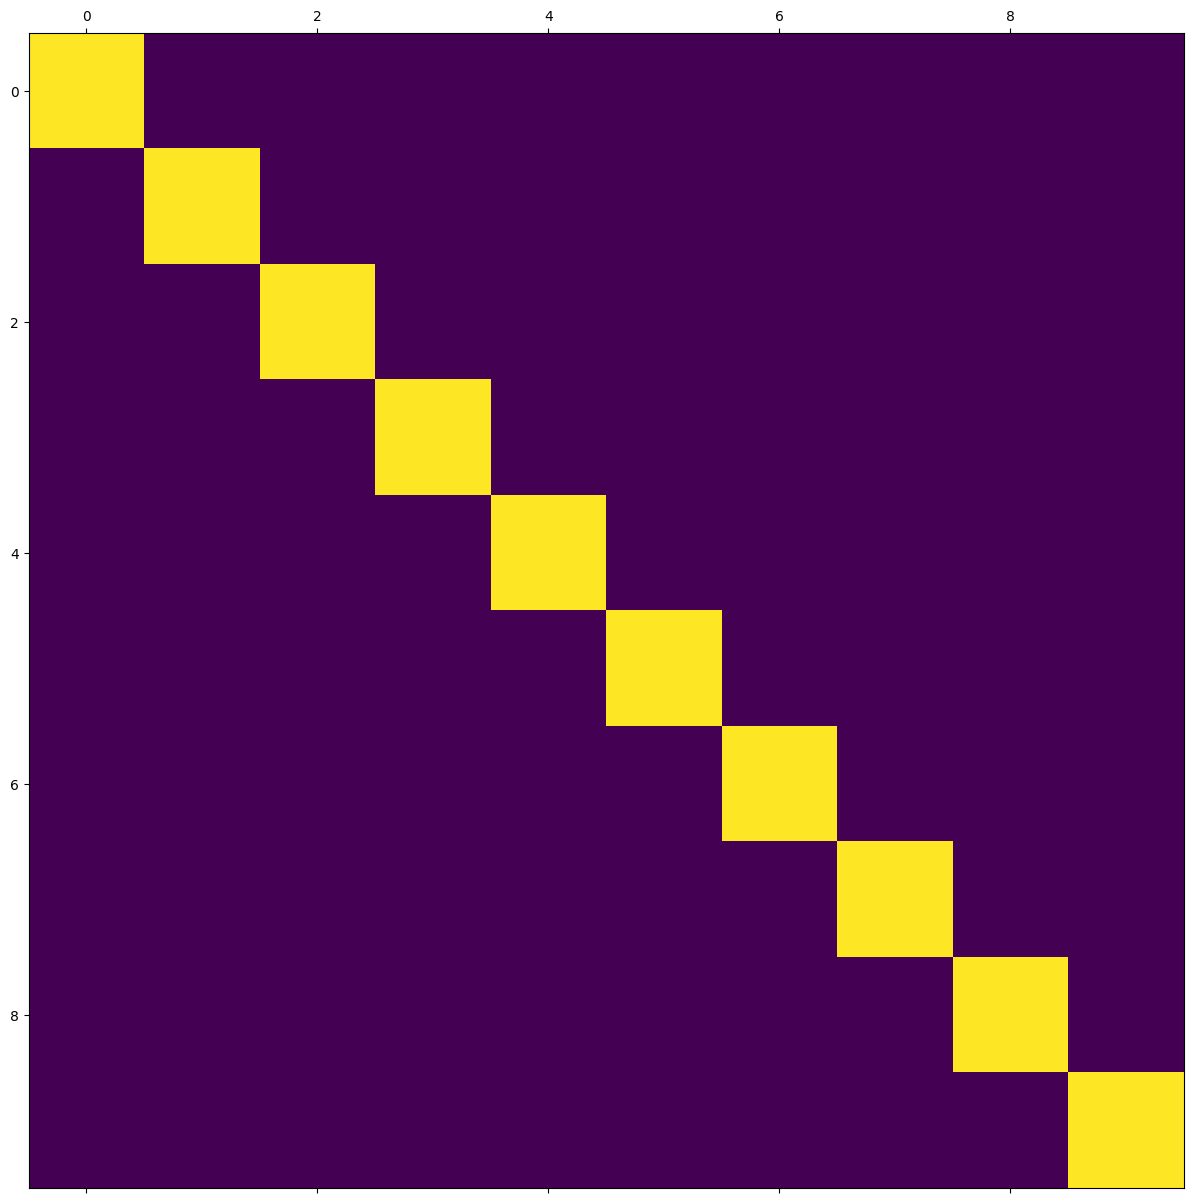

In [72]:
svd_return_corr = svd_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(svd_return_corr)

## Causal Discovery

In [11]:
model = lingam.ICALiNGAM(random_state=123, max_iter=1000000)

model.fit(simple_return_df)
print(simple_return_df.columns)
print(model.causal_order_)
print(model.adjacency_matrix_)

KeyboardInterrupt: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


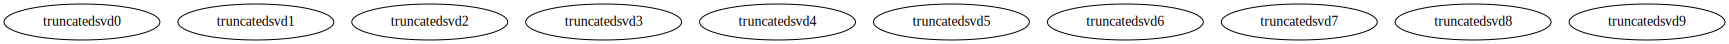

In [82]:
# On the PCAd dataset:
svd_model = lingam.ICALiNGAM(random_state=123, max_iter=int(1e6))

svd_model.fit(svd_df)

with open('/wd/ICA_LINGAM_SVD.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=5)

print( svd_model.adjacency_matrix_ )

svd_graph_dot = make_dot(svd_model.adjacency_matrix_, labels=[f'{col}' for i, col in enumerate(svd_df.columns)])
svd_graph_dot

In [23]:
with open('/wd/ICA_LINGAM.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=5)

In [12]:
unpicked = 0
with open('/wd/ICA_LINGAM.pkl', 'rb') as f:
    unpicked = pickle.load(f)
model = unpicked

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(18, 11), dpi=360)

<Figure size 6480x3960 with 0 Axes>

<Figure size 6480x3960 with 0 Axes>

In [16]:
print(simple_return_df.columns)

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', length=497)


In [15]:
model.adjacency_matrix_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31111362,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.40511771,  0.07227639,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.006733  ,  0.        ,  0.03963423, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

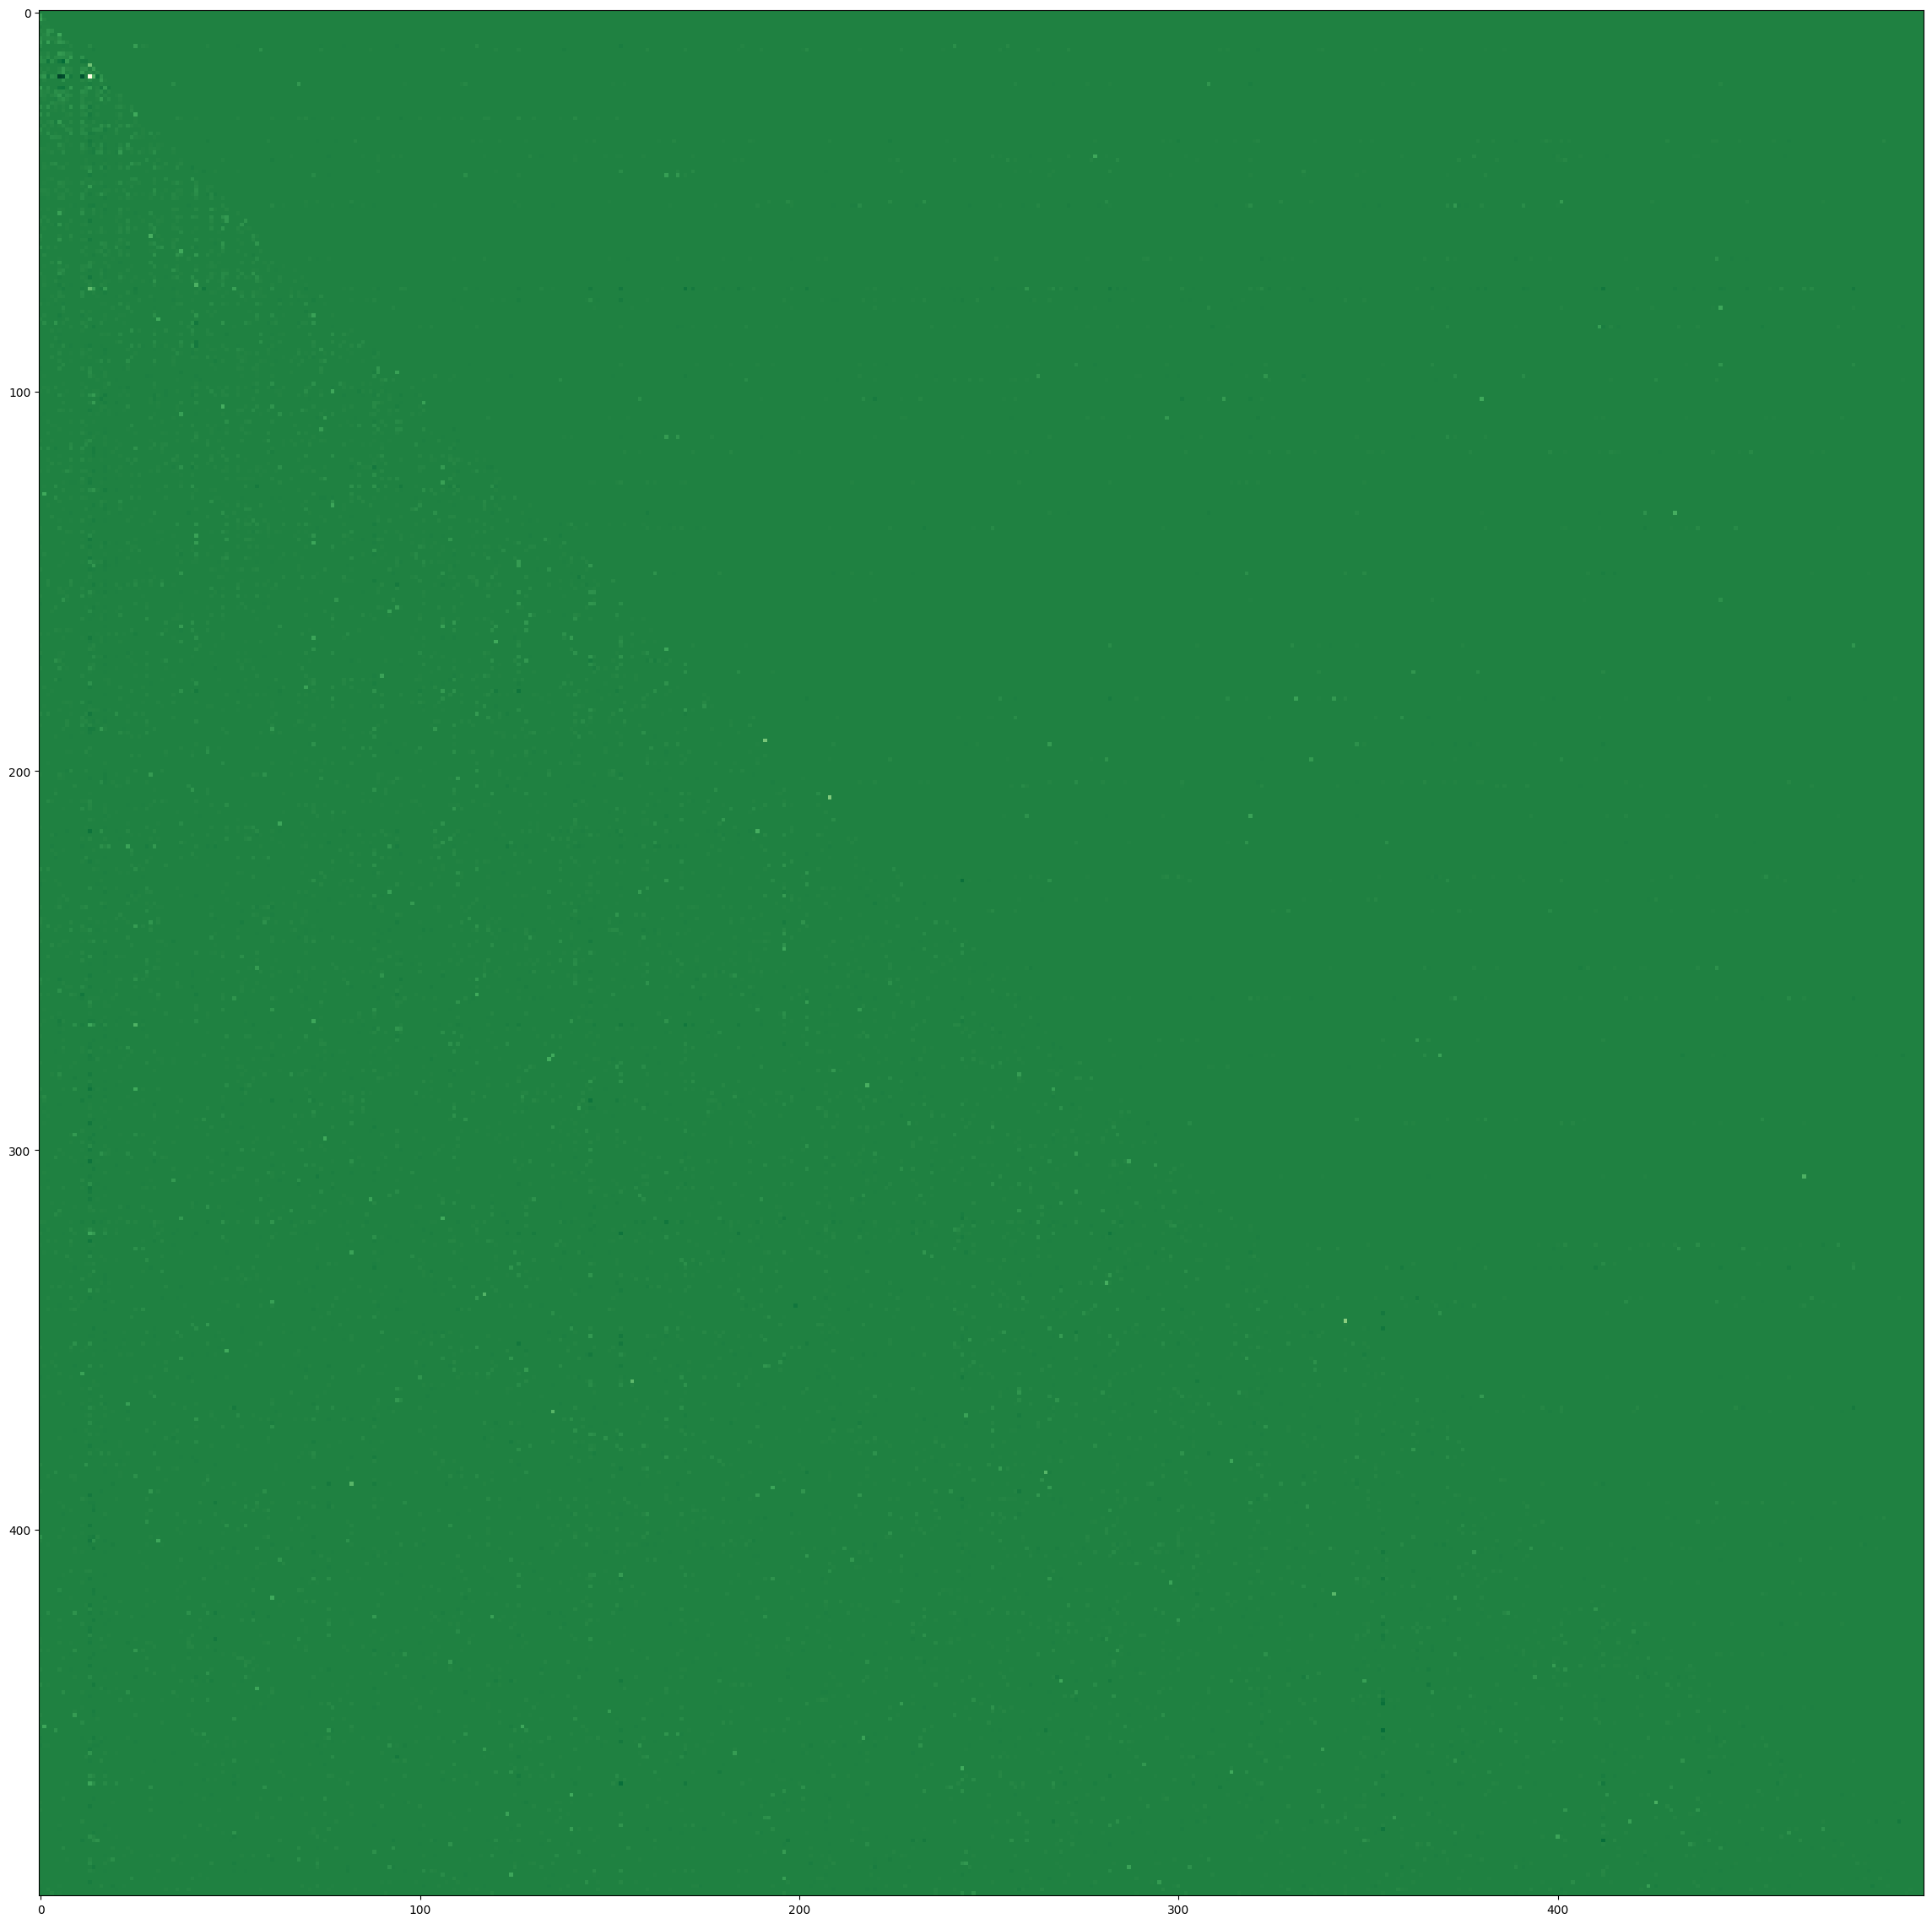

In [14]:
f = plt.figure()
f.set_figwidth(29)
f.set_figheight(29)

plt.imshow(model.adjacency_matrix_, cmap='YlGn_r') # dark shows closer to 0, light closer to 1.  if p-value < 0.05 reject indep. -> dependent.

In [36]:
p_values = model.get_error_independence_p_values(simple_return_df)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
plt.imshow(p_values, cmap='YlGn_r') # dark shows closer to 0, light closer to 1.  if p-value < 0.05 reject indep. -> dependent.

In [64]:
graph_dot = make_dot(model.adjacency_matrix_, labels=[f'{col}' for i, col in enumerate(simple_return_df.columns)])
graph_dot

KeyboardInterrupt: 

# Random Garbage

Assume:

APPL -> MSFT -> SPX 

Then: causal effect of APPL on SPX is equal to the beta of SPX ~ APPL + MSFT (parents used as an adjustment set)


In [6]:
apple_close

,AAPL
Date,
2000-01-03 00:00:00,0.999442
2000-01-04 00:00:00,0.915179
2000-01-05 00:00:00,0.928571
2000-01-06 00:00:00,0.848214
2000-01-07 00:00:00,0.888393
...,...
2022-12-23 00:00:00,131.860001
2022-12-27 00:00:00,130.029999
2022-12-28 00:00:00,126.040001


In [7]:
msft_close

,MSFT
Date,
2000-01-03 00:00:00,58.281250
2000-01-04 00:00:00,56.312500
2000-01-05 00:00:00,56.906250
2000-01-06 00:00:00,55.000000
2000-01-07 00:00:00,55.718750
...,...
2022-12-23 00:00:00,238.729996
2022-12-27 00:00:00,236.960007
2022-12-28 00:00:00,234.529999


In [8]:
X = pd.merge( apple_close, msft_close, on = 'Date', how='inner').dropna()
X.head()

,AAPL,MSFT
Date,,
2000-01-03 00:00:00,0.999442,58.28125
2000-01-04 00:00:00,0.915179,56.31250
2000-01-05 00:00:00,0.928571,56.90625
2000-01-06 00:00:00,0.848214,55.00000
2000-01-07 00:00:00,0.888393,55.71875


In [9]:
model = LinearRegression(fit_intercept=False).fit(X, spx_close.dropna())

In [10]:
print(model.coef_)

[[-36.06404095  37.18580826]]


Causal effect is -36?

<Axes: xlabel='Date'>

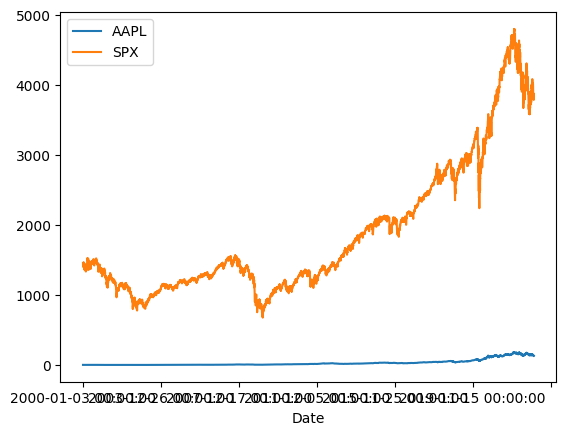

In [11]:

apple_close.join(spx_close).plot()

In [12]:
model2 = sm.OLS(spx_close, apple_close).fit()

#view model summary
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SPX   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                          1.729e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):                        0.00
Time:                        22:40:20   Log-Likelihood:                         -48499.
No. Observations:                5787   AIC:                                  9.700e+04
Df Residuals:                    5786   BIC:                                  9.701e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
print(LinearRegression(fit_intercept=False).fit(msft_close, spx_close).coef_)

[[19.01065926]]


<Axes: xlabel='Date'>

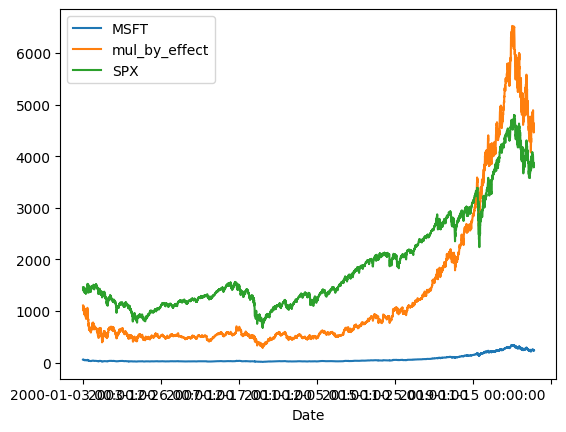

In [14]:
msft_close.assign(mul_by_effect=lambda x: x['MSFT'] * 19.01).join(spx_close).plot()

In [15]:
print(LinearRegression(fit_intercept=False).fit(msft_close, apple_close).coef_)

[[0.50396873]]


In [16]:
data = pd.merge(X, spx_close, on='Date', how='inner')
data.head()

,AAPL,MSFT,SPX
Date,,,
2000-01-03 00:00:00,0.999442,58.28125,1455.219971
2000-01-04 00:00:00,0.915179,56.31250,1399.420044
2000-01-05 00:00:00,0.928571,56.90625,1402.109985
2000-01-06 00:00:00,0.848214,55.00000,1403.449951
2000-01-07 00:00:00,0.888393,55.71875,1441.469971


In [59]:

model= CausalModel(data=data, common_causes='AAPL', treatment='MSFT', outcome='SPX')
model.view_model(layout="dot")

NameError: name 'data' is not defined

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                
───────(E[SPX|AAPL])
d[MSFT]             
Estimand assumption 1, Unconfoundedness: If U→{MSFT} and U→SPX then P(SPX|MSFT,AAPL,U) = P(SPX|MSFT,AAPL)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Causal Estimate is 5.232898071925774


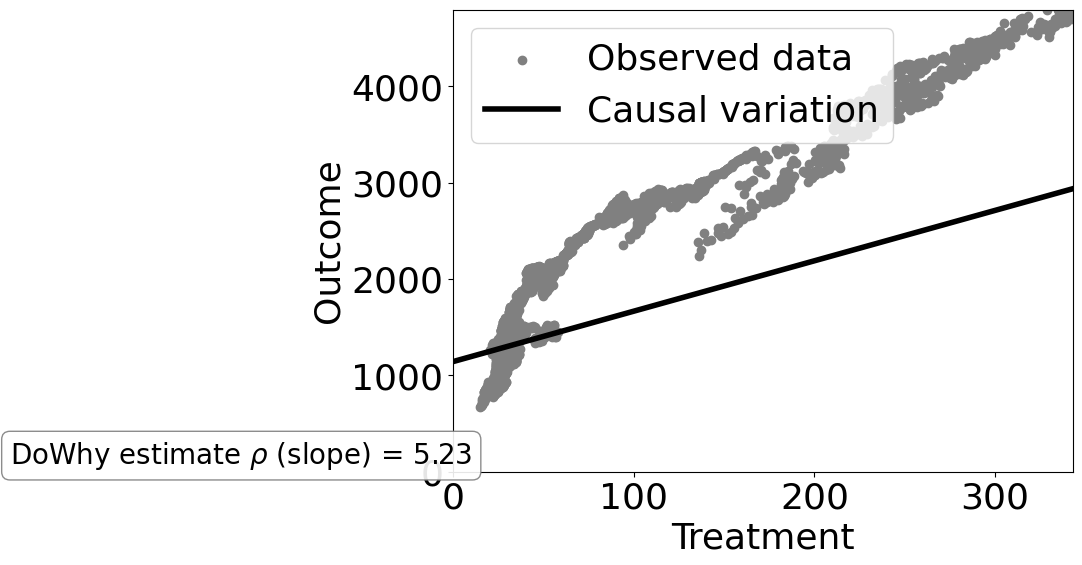

In [19]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, data['MSFT'], data['SPX'])

In [20]:
res_random=model.refute_estimate(estimand=identified_estimand, estimate=estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:5.232898071925774
New effect:5.233080162128797
p value:0.78



In [21]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:5.232898071925774
New effect:-0.003996977246483766
p value:0.84



In [22]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:5.232898071925774
New effect:5.233174282639441
p value:0.98



<Axes: xlabel='Date'>

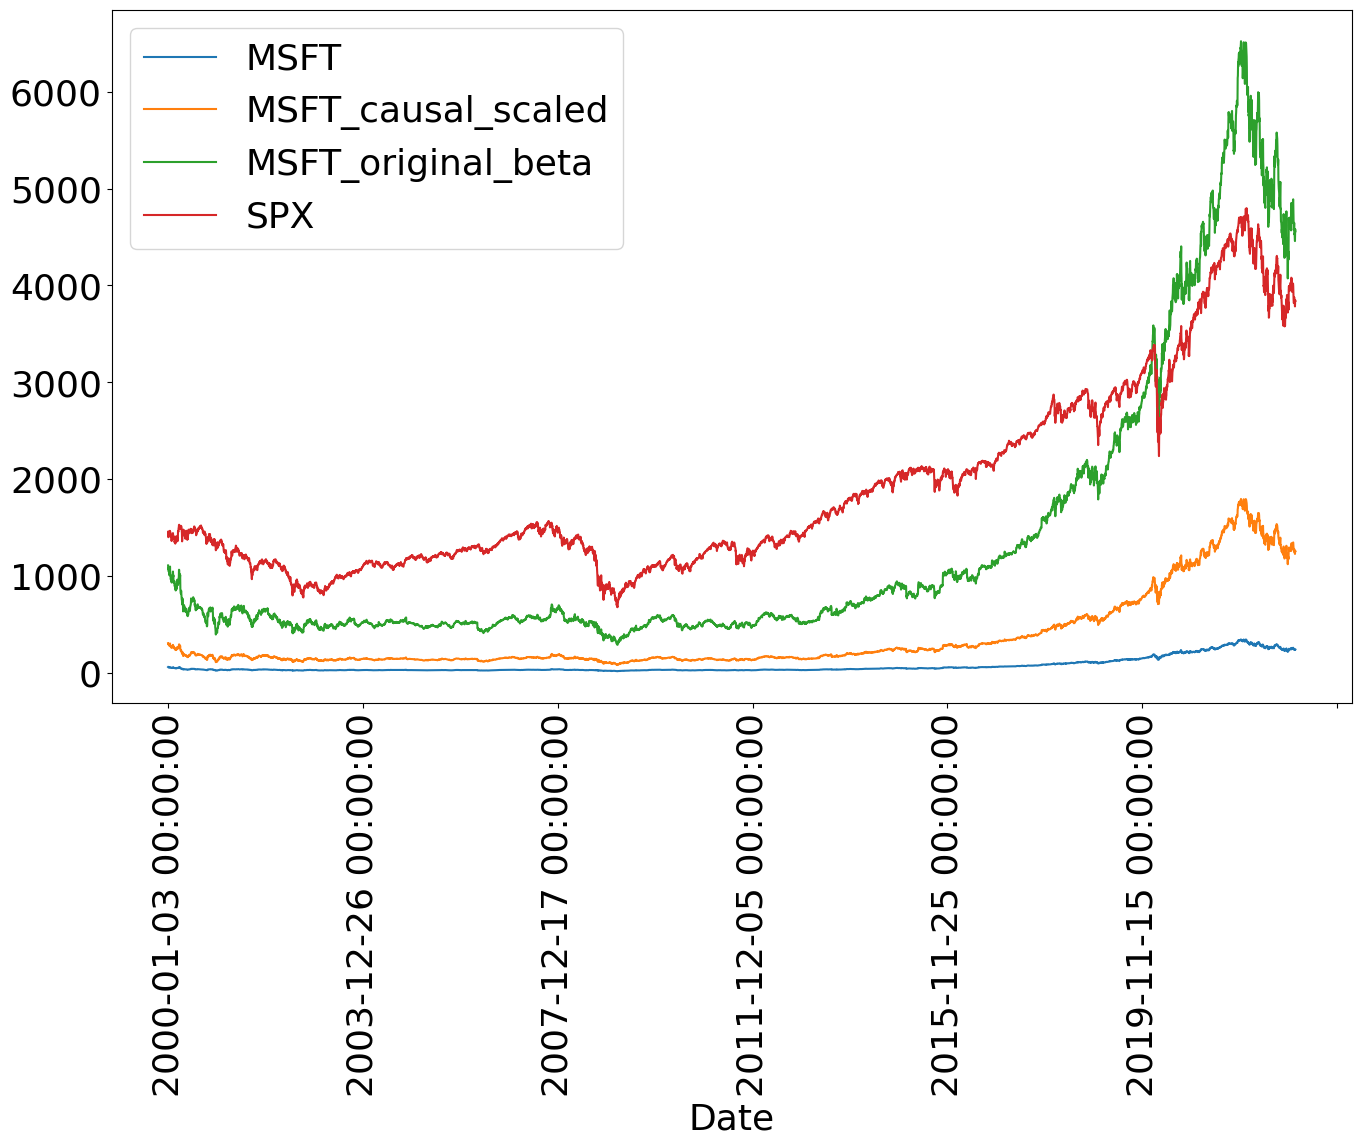

In [23]:
msft_close.assign(MSFT_causal_scaled=lambda x: x['MSFT'] * 5.23).assign(MSFT_original_beta = lambda x: x['MSFT']*19.01).join(spx_close).plot(figsize=(16,9), rot=90)

In [24]:
from dowhy import gcm

In [25]:
scm = gcm.StructuralCausalModel(model)
gcm.auto.assign_causal_mechanisms(scm, data)
gcm.fit(scm, data)

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 1327.45it/s]
/usr/local/lib/python3.10/dist-packages/dowhy/gcm/falsify.py:727: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


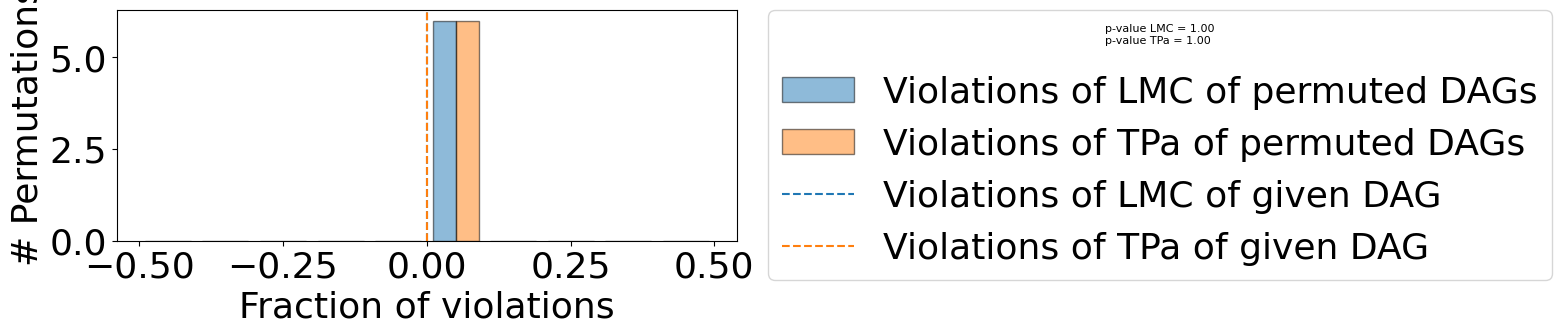

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [26]:
print(gcm.evaluate_causal_model(scm, data, evaluate_invertibility_assumptions=True, evaluate_causal_structure=True))

In [27]:
from dowhy.utils.plotting import plot, bar_plot

{('AAPL', 'SPX'): 170354.44197468515, ('MSFT', 'SPX'): 252813.56583857242}


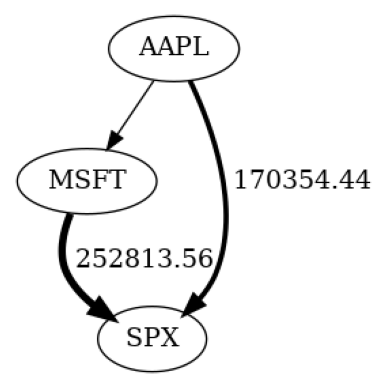

In [28]:
arrow_strengths_spx = gcm.arrow_strength(scm, target_node='SPX')
print(arrow_strengths_spx)
dowhy.utils.plotting.plot(scm.graph, causal_strengths=arrow_strengths_spx)

In [29]:
#strength_median, strength_intervals = gcm.confidence_intervals(
#    gcm.bootstrap_sampling(gcm.arrow_strength, scm,target_node='SPX'))
#strength_median, strength_intervals

strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, scm, bootstrap_training_data=data, target_node='SPX'),
    num_bootstrap_resamples=50,
    n_jobs=10,
)
strength_median, strength_intervals

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


({('AAPL', 'SPX'): 150399.6258657997, ('MSFT', 'SPX'): 272155.8498815274},
 {('AAPL', 'SPX'): array([102987.14520652, 217700.90362036]),
  ('MSFT', 'SPX'): array([196320.45262818, 337950.63324043])})

In [30]:
iccs_spx = gcm.intrinsic_causal_influence(scm, target_node='SPX')

Evaluate set function: 8it [00:00, 23763.76it/s]


In [31]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [32]:
halving_msft = gcm.interventional_samples(scm,
                                        {'MSFT': lambda y: y/2 },
                                        num_samples_to_draw=1000)
halving_aapl = gcm.interventional_samples(scm,
                                        {'AAPL': lambda y: y/2 },
                                        num_samples_to_draw=1000)
print(f"Effect of halving all MSFT observations on average SPX: {data['SPX'].mean() - halving_msft['SPX'].mean()}")
print(f"Effect of halving all AAPL observations on average SPX: {data['AAPL'].mean() - halving_aapl['AAPL'].mean()}")

Effect of halving all MSFT observations on average SPX: 413.86946965071684
Effect of halving all AAPL observations on average SPX: 14.17490120966321


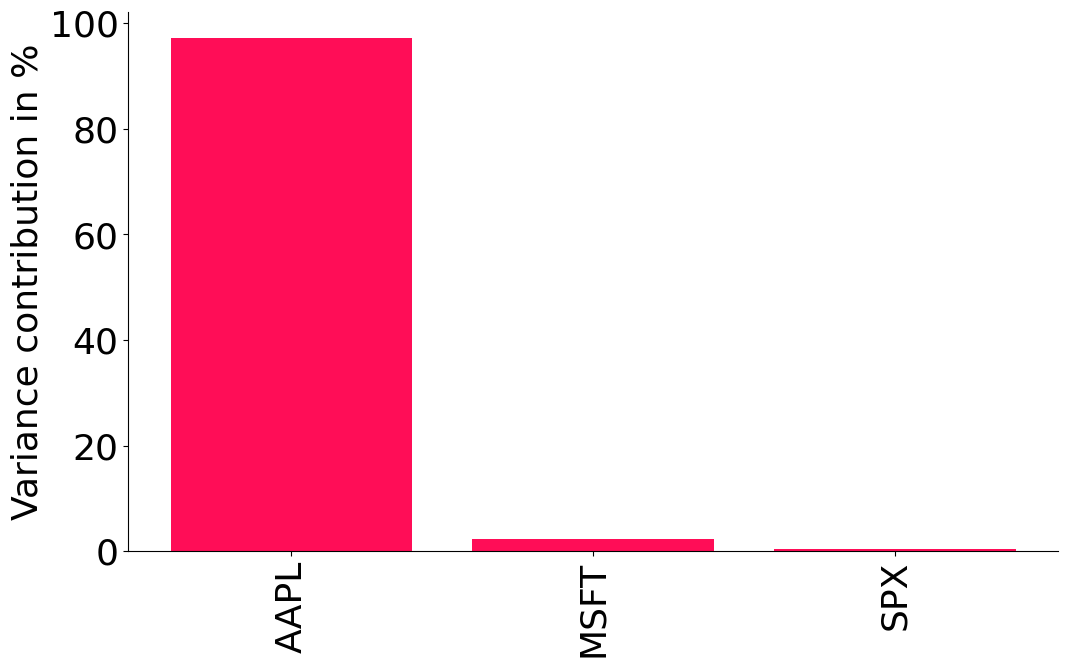

In [33]:
bar_plot(convert_to_percentage(iccs_spx), ylabel='Variance contribution in %', figure_size=(12,7))

In [34]:
data.head()
data.tail(15)

,AAPL,MSFT,SPX
Date,,,
2022-12-09 00:00:00,142.160004,245.419998,3934.379883
2022-12-12 00:00:00,144.490005,252.509995,3990.560059
2022-12-13 00:00:00,145.470001,256.920013,4019.649902
2022-12-14 00:00:00,143.210007,257.220001,3995.320068
2022-12-15 00:00:00,136.500000,249.009995,3895.750000
2022-12-16 00:00:00,134.509995,244.690002,3852.360107
2022-12-19 00:00:00,132.369995,240.449997,3817.659912
2022-12-20 00:00:00,132.300003,241.800003,3821.620117
2022-12-21 00:00:00,135.449997,244.429993,3878.439941


In [35]:
data.head()

,AAPL,MSFT,SPX
Date,,,
2000-01-03 00:00:00,0.999442,58.28125,1455.219971
2000-01-04 00:00:00,0.915179,56.31250,1399.420044
2000-01-05 00:00:00,0.928571,56.90625,1402.109985
2000-01-06 00:00:00,0.848214,55.00000,1403.449951
2000-01-07 00:00:00,0.888393,55.71875,1441.469971


In [36]:
logreturns = data.copy()
for ticker in data.columns:
    logreturns[ticker] = np.log1p(data[ticker].pct_change())

logreturns = logreturns.dropna()
logreturns.tail(10)

,AAPL,MSFT,SPX
Date,,,
2022-12-16 00:00:00,-0.014686,-0.017501,-0.011200
2022-12-19 00:00:00,-0.016038,-0.017480,-0.009048
2022-12-20 00:00:00,-0.000529,0.005599,0.001037
2022-12-21 00:00:00,0.023530,0.010818,0.014759
2022-12-22 00:00:00,-0.024060,-0.025860,-0.014557
2022-12-23 00:00:00,-0.002802,0.002265,0.005851
2022-12-27 00:00:00,-0.013976,-0.007442,-0.004058
2022-12-28 00:00:00,-0.031166,-0.010308,-0.012093
2022-12-29 00:00:00,0.027931,0.027255,0.017311


In [37]:
#logreturns.loc['2020-01-01': '2022-01-01'].tail()

In [38]:
logreturns_1w = logreturns.loc['2022-12-27' : '2022-12-31'] # data from the last week of observations (4 days)
logreturns_1m = logreturns.loc['2022-12-01' : '2022-12-27'] # data from the last month (december) but excluding the last week
logreturns_3m = logreturns.loc['2022-09-01' : '2022-12-01'] # data from last three months excluding the last month (and last week)
logreturns_6m = logreturns.loc['2022-06-01' : '2022-09-01'] # last 6m excluding last 3m 
logreturns_1y = logreturns.loc['2022-01-03' : '2022-06-01'] # similarly
logreturns_3y = logreturns.loc['2020-01-02' : '2022-01-03'] # similarly

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'SPX'}>, <Axes: >]], dtype=object)

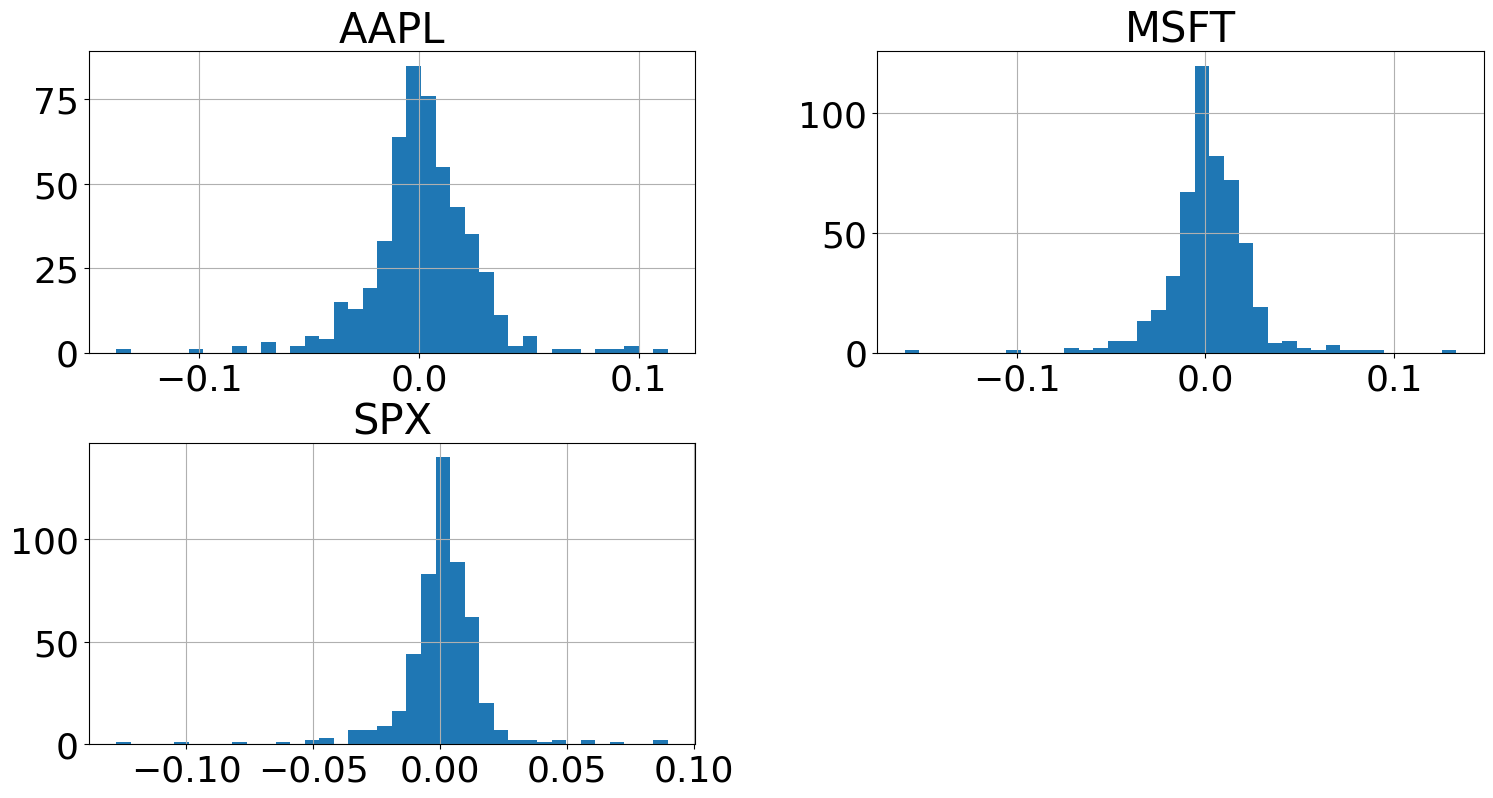

In [39]:
logreturns_3y.hist(bins=int(np.sqrt(logreturns_3y.size)), figsize=(18,9))

In [40]:
lrt_scm = gcm.StructuralCausalModel(model)
gcm.auto.assign_causal_mechanisms(lrt_scm, logreturns_3m)
gcm.fit(lrt_scm, logreturns_3m)

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00, 485.00it/s]


In [41]:
#print(gcm.evaluate_causal_model(lrt_scm, logreturns_3m, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

In [42]:
iccs_lrt_3m = gcm.intrinsic_causal_influence(lrt_scm, target_node='SPX')

Evaluate set function: 8it [00:00, 28268.27it/s]


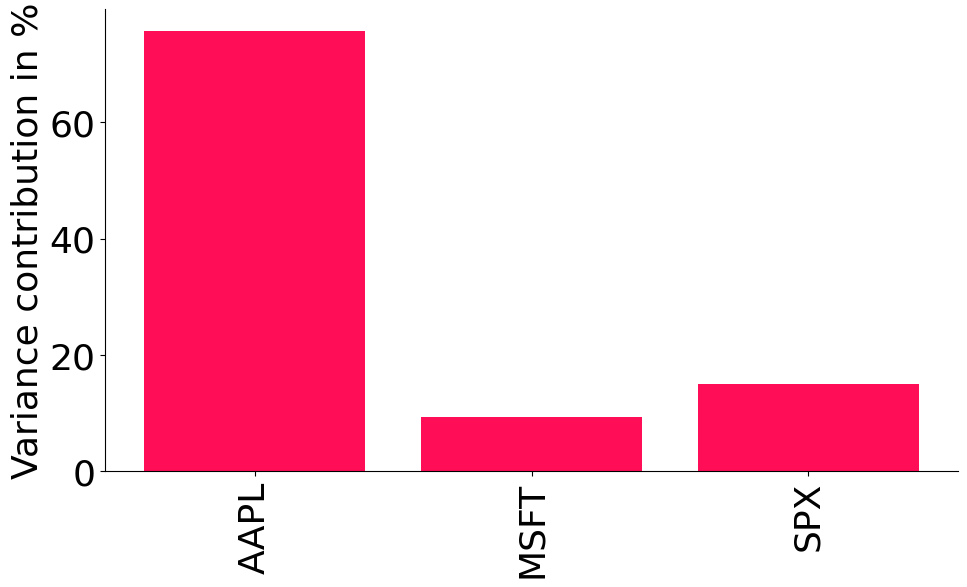

In [43]:
bar_plot(convert_to_percentage(iccs_lrt_3m), ylabel='Variance contribution in %', figure_size=(11,6))

In [44]:
# Merge into one dataset where columns represent the time period and rows are non-zero in each period only.
merged = data[[]] # just the index (dates)
frequency_lrs = {
    "1w" : logreturns_1w,
    "1m" : logreturns_1m,
    "3m" : logreturns_3m,
    "6m" : logreturns_6m,
    "1y" : logreturns_1y,
    "3y" : logreturns_3y,
}
frequency_lrs = {freq:df.rename(columns={col:col+freq for col in logreturns.columns}) for freq,df in frequency_lrs.items()}

for freq, df in frequency_lrs.items():
    merged = merged.join(df, how='left', on = 'Date')

merged = merged.fillna(0)
merged.tail(6)

,AAPL1w,MSFT1w,SPX1w,AAPL1m,MSFT1m,SPX1m,AAPL3m,MSFT3m,SPX3m,AAPL6m,MSFT6m,SPX6m,AAPL1y,MSFT1y,SPX1y,AAPL3y,MSFT3y,SPX3y
Date,,,,,,,,,,,,,,,,,,
2022-12-22 00:00:00,0.000000,0.000000,0.000000,-0.024060,-0.025860,-0.014557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-23 00:00:00,0.000000,0.000000,0.000000,-0.002802,0.002265,0.005851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-27 00:00:00,-0.013976,-0.007442,-0.004058,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28 00:00:00,-0.031166,-0.010308,-0.012093,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-29 00:00:00,0.027931,0.027255,0.017311,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30 00:00:00,0.002466,-0.004950,-0.002544,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
import networkx as nx

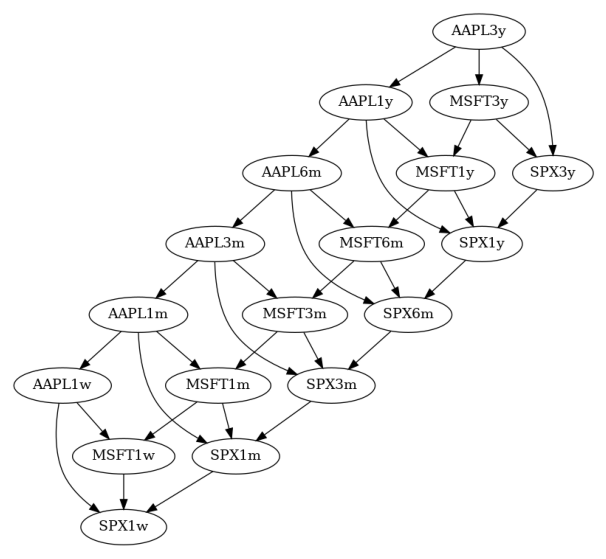

In [46]:
def freq_cols(freq:str, df):
    return [x for x in merged.columns if x.endswith(freq)]

edges = []
for posterior, prior in zip(list(frequency_lrs), list(frequency_lrs)[1:]):
    edges += [(cause,effect) for cause,effect in zip(freq_cols(prior, merged), freq_cols(posterior, merged))]
    edges += [('AAPL'+prior, 'MSFT'+prior)]
    edges += [('MSFT'+prior, 'SPX'+prior)]
    edges += [('AAPL'+prior, 'SPX'+prior)]

edges += [('AAPL1w', 'SPX1w'), ('AAPL1w', 'MSFT1w'), ('MSFT1w', 'SPX1w')]
graph = nx.DiGraph(edges)
general_model = gcm.StructuralCausalModel(graph)
gcm.util.plot(graph, figure_size=(11,7))

In [47]:
gcm.auto.assign_causal_mechanisms(general_model, merged)
gcm.fit(general_model, merged)

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 103.74it/s]


In [48]:
print(gcm.evaluate_causal_model(general_model, merged, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...: 100%|██████████| 18/18 [00:00<00:00, 26649.30it/s]


Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked Probability Score (CRPS):

In [49]:
iccs_general_spx1w = gcm.intrinsic_causal_influence(general_model, target_node='SPX1w')
iccs_general_spx1m = gcm.intrinsic_causal_influence(general_model, target_node='SPX1m')

Estimating Shapley Values. Average change of Shapley values in run 41 (205 evaluated permutations): 0.8892084673958985%: 100%|██████████| 1/1 [01:08<00:00, 68.34s/it]
Estimating Shapley Values. Average change of Shapley values in run 33 (165 evaluated permutations): 1.224055805363143%: 100%|██████████| 1/1 [00:36<00:00, 36.45s/it]


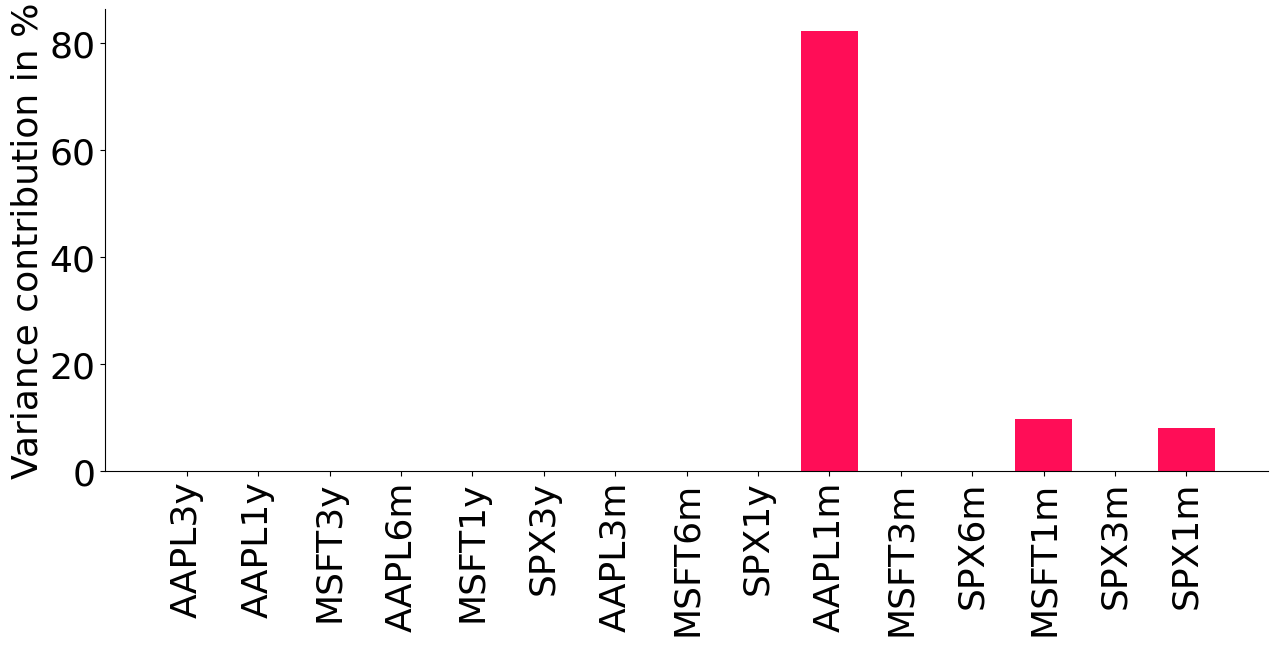

In [50]:
bar_plot(convert_to_percentage(iccs_general_spx1m), ylabel='Variance contribution in %', figure_size=(15,6))

In [51]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, general_model, bootstrap_training_data=merged, target_node='SPX1m'),
    num_bootstrap_resamples=300,
    n_jobs=10,
)
strength_median, strength_intervals

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 210.85it/s]


({('AAPL1m', 'SPX1m'): 5.624266996183007e-08,
  ('MSFT1m', 'SPX1m'): 1.5598244722288992e-07,
  ('SPX3m', 'SPX1m'): -1.8077271140058439e-09},
 {('AAPL1m', 'SPX1m'): array([1.10785025e-08, 1.22889635e-07]),
  ('MSFT1m', 'SPX1m'): array([5.82468072e-08, 2.64412876e-07]),
  ('SPX3m', 'SPX1m'): array([-3.97653752e-09,  3.89265559e-09])})

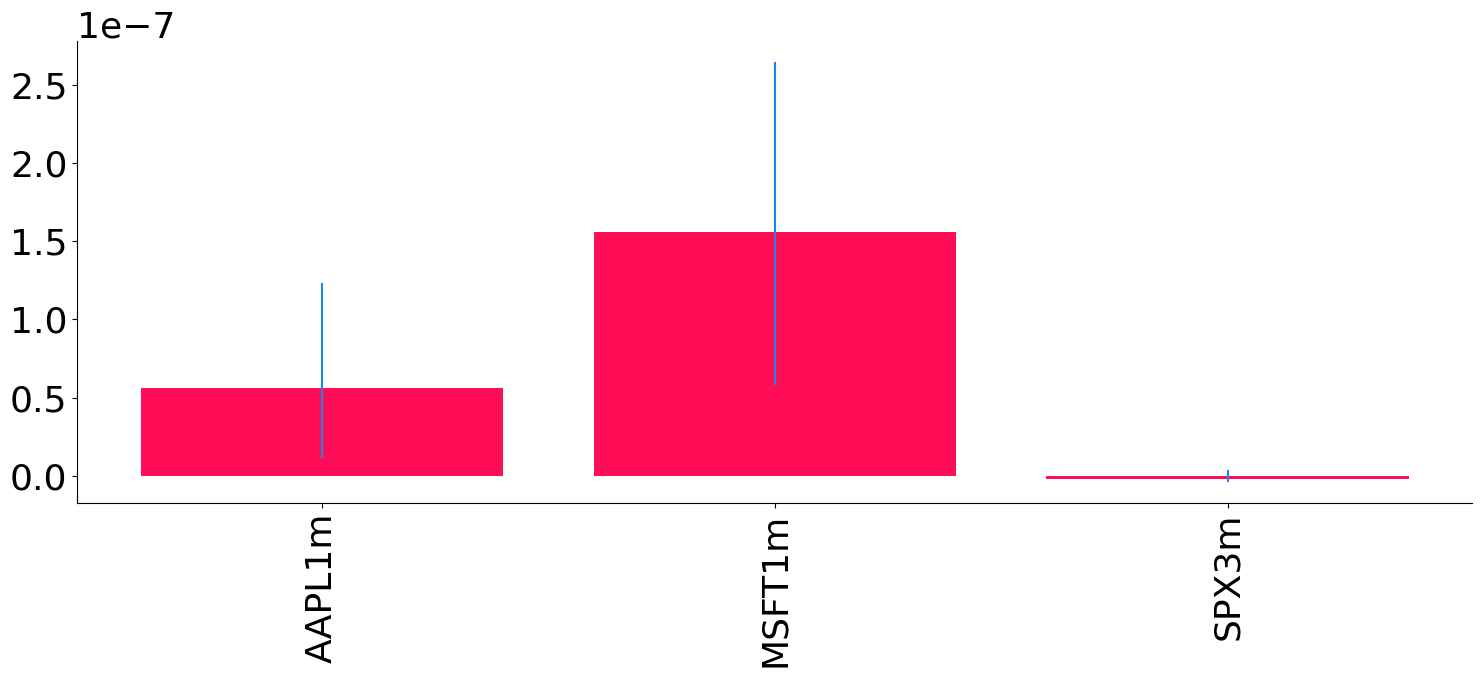

In [52]:
bar_plot({k[0]: v for k, v in strength_median.items()}, uncertainties={k[0]: v for k, v in strength_intervals.items()}, figure_size=(18,6))

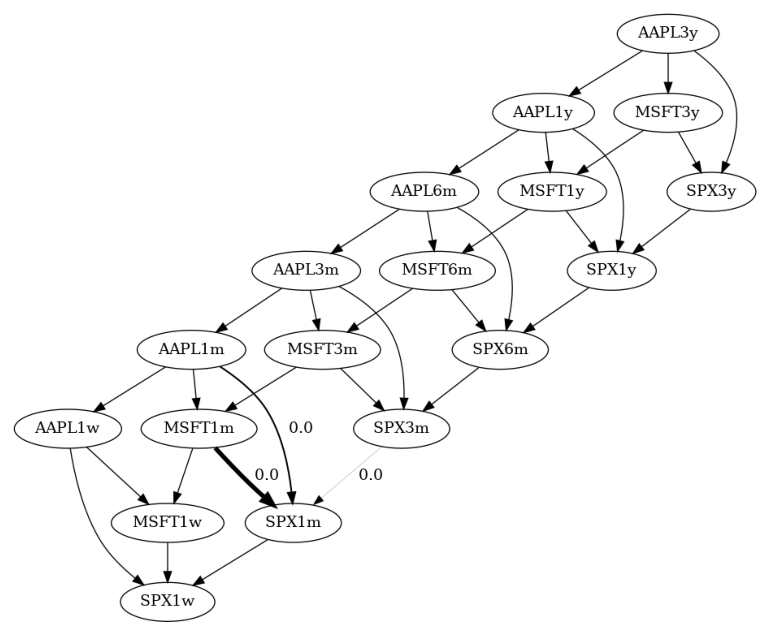

In [53]:
dowhy.utils.plotting.plot(general_model.graph, causal_strengths=strength_median, figure_size=(13,8))

Evaluate set function: 32it [00:00, 73867.76it/s]


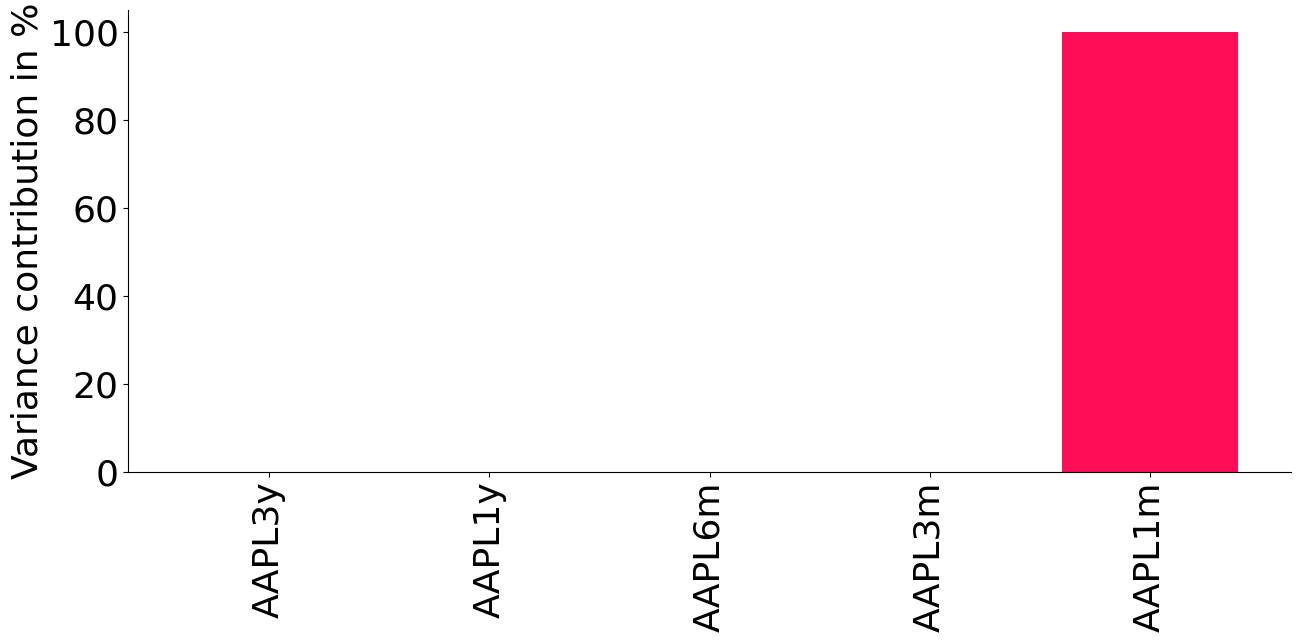

In [54]:
iccs_general_aapl1m = gcm.intrinsic_causal_influence(general_model, target_node='AAPL1m')
bar_plot(convert_to_percentage(iccs_general_aapl1m), ylabel='Variance contribution in %', figure_size=(15,6))

In [55]:
strength_median_aapl1m, strength_intervals_aapl1m = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, general_model, bootstrap_training_data=merged, target_node='AAPL1m'),
    num_bootstrap_resamples=300,
    n_jobs=10,
)
strength_median_aapl1m, strength_intervals_aapl1m

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 189.26it/s]


({('AAPL3m', 'AAPL1m'): -5.3655955589753336e-11},
 {('AAPL3m', 'AAPL1m'): array([-1.53311871e-07,  1.50805815e-07])})

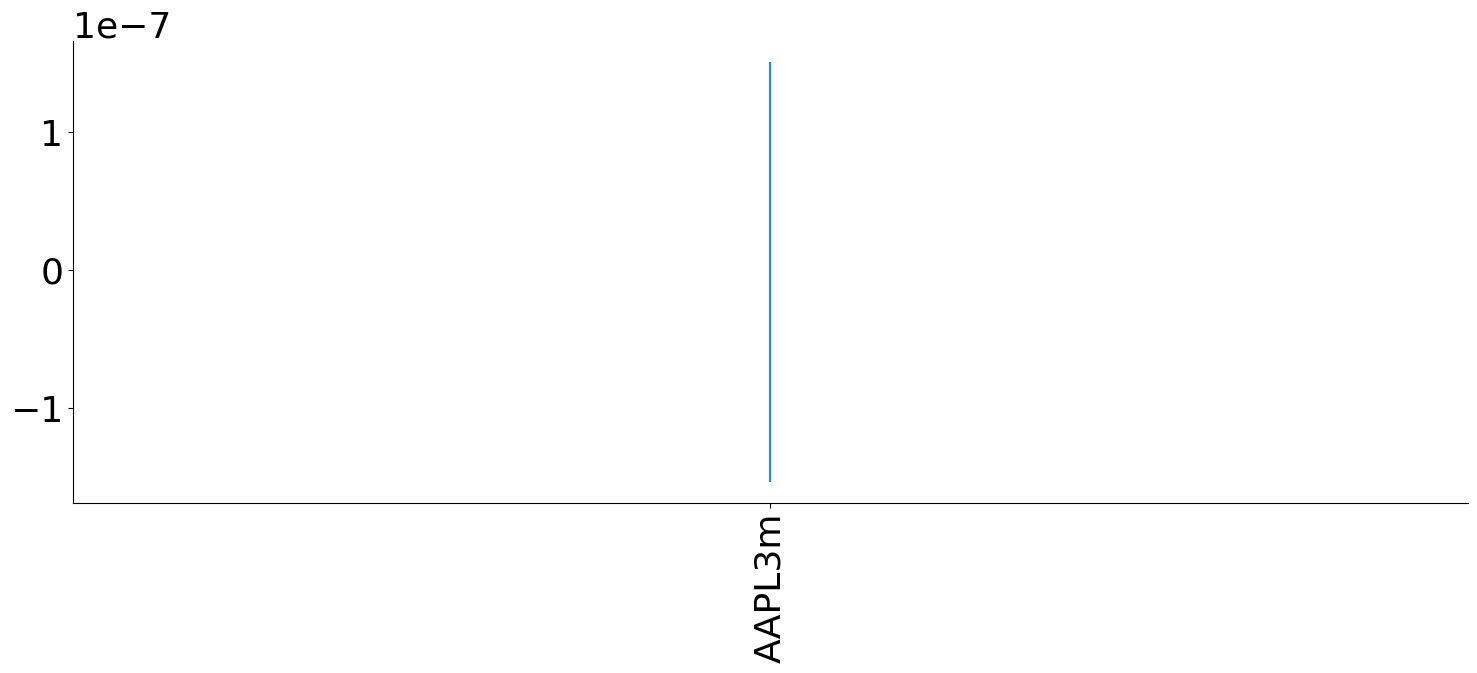

In [56]:
bar_plot({k[0]: v for k, v in strength_median_aapl1m.items()}, uncertainties={k[0]: v for k, v in strength_intervals_aapl1m.items()}, figure_size=(18,6))

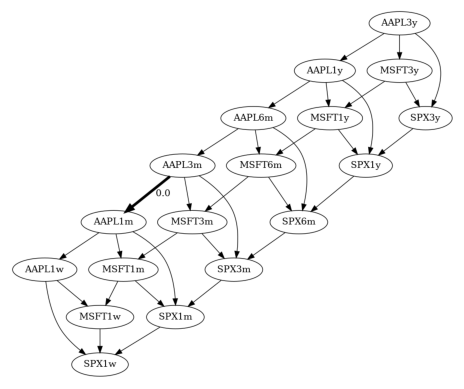

In [57]:
dowhy.utils.plotting.plot(general_model.graph, causal_strengths=strength_median_aapl1m)

In [58]:
window_length_days = 30
new_data = pd.merge( apple_close, msft_close, on = 'Date', how='inner')
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on='Date', how='inner'), [ apple_close, msft_close, spx_close, mbk_close, gpw_close, ale_close ] ).dropna()
df_merged.tail()

,AAPL,MSFT,SPX,MBK,GPW,ALE
Date,,,,,,
2022-12-23 00:00:00,131.860001,238.729996,3844.820068,300.000000,35.139999,25.379999
2022-12-27 00:00:00,130.029999,236.960007,3829.250000,287.000000,34.400002,24.830000
2022-12-28 00:00:00,126.040001,234.529999,3783.219971,293.000000,34.500000,24.889999
2022-12-29 00:00:00,129.610001,241.009995,3849.280029,296.799988,35.099998,25.514999
2022-12-30 00:00:00,129.929993,239.820007,3839.500000,296.000000,35.520000,25.129999


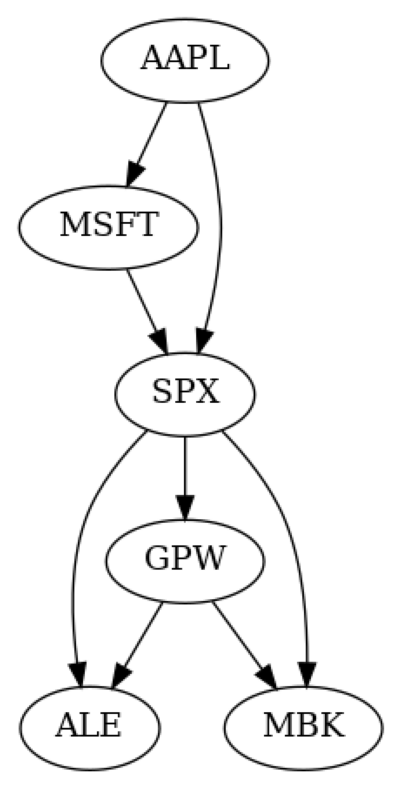

In [59]:
edges = [("MSFT", "SPX"), ("AAPL", "SPX"), ("AAPL", "MSFT"), ("SPX", "GPW"), ("GPW", "ALE"), ("GPW", "MBK"), ("SPX", "ALE"), ("SPX", "MBK")]
graph = nx.DiGraph(edges)
us_pl_model = gcm.StructuralCausalModel(graph)
gcm.util.plot(graph, figure_size=(16,10))

In [60]:
start   = '2022-10-10'
end     = '2022-11-30'
target_ticker = "ALE"
var_contribs = {}
for r in df_merged[start:end].rolling(window_length_days):
    if( len(r) != window_length_days ):
        continue
    us_pl_model = gcm.StructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(us_pl_model, r)
    gcm.fit(us_pl_model, r)
    ici = gcm.intrinsic_causal_influence(us_pl_model, target_node=target_ticker)
    current_contrib = convert_to_percentage(ici)
    var_contribs[ ( r.index[0], r.index[-1] ) ] = current_contrib
    

Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 499.88it/s]
Evaluate set function: 32it [00:00, 34753.43it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 521.19it/s]
Evaluate set function: 32it [00:00, 92755.86it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 985.43it/s]
Evaluate set function: 32it [00:00, 71278.67it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 536.76it/s]
Evaluate set function: 32it [00:00, 91180.52it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 460.17it/s]
Evaluate set function: 32it [00:00, 41956.15it/s]


In [61]:
var_contribs

{('2022-10-10 00:00:00', '2022-11-22 00:00:00'): {'AAPL': 34.527595791755274,
  'MSFT': 0.38214127722340535,
  'SPX': 31.6431541381777,
  'GPW': 22.747526544906044,
  'ALE': 10.699582247937567},
 ('2022-10-11 00:00:00', '2022-11-23 00:00:00'): {'AAPL': 32.92349346811284,
  'MSFT': 0.645511330291985,
  'SPX': 28.57896749938244,
  'GPW': 25.19473403957167,
  'ALE': 12.657293662641067},
 ('2022-10-12 00:00:00', '2022-11-25 00:00:00'): {'AAPL': 31.198924891556523,
  'MSFT': 1.674149369781397,
  'SPX': 29.734486334097138,
  'GPW': 23.942102123855484,
  'ALE': 13.450337280709462},
 ('2022-10-13 00:00:00', '2022-11-28 00:00:00'): {'AAPL': 22.07150944551132,
  'MSFT': 1.5354939300863248,
  'SPX': 33.282423238336825,
  'GPW': 28.660638701936776,
  'ALE': 14.44993468412876},
 ('2022-10-14 00:00:00', '2022-11-29 00:00:00'): {'AAPL': 19.06878856806578,
  'MSFT': 3.431010045355439,
  'SPX': 31.89880559885455,
  'GPW': 32.95587030530437,
  'ALE': 12.645525482419865}}

In [62]:
plot_data = {k: list() for k in list(var_contribs.values())[0].keys()}
for key, elem in var_contribs.items():
    for ticker, contribution in elem.items():
        plot_data[ticker].append( contribution )

In [63]:
spx_supplement = spx_close.rename(columns={'SPX': 'SPX-close'}) / 100
aapl_supplement = apple_close.rename(columns={'AAPL': 'AAPL-close '}) / 10
msft_supplement = msft_close.rename(columns={'MSFT': 'MSFT-close '}) / 10

<Axes: >

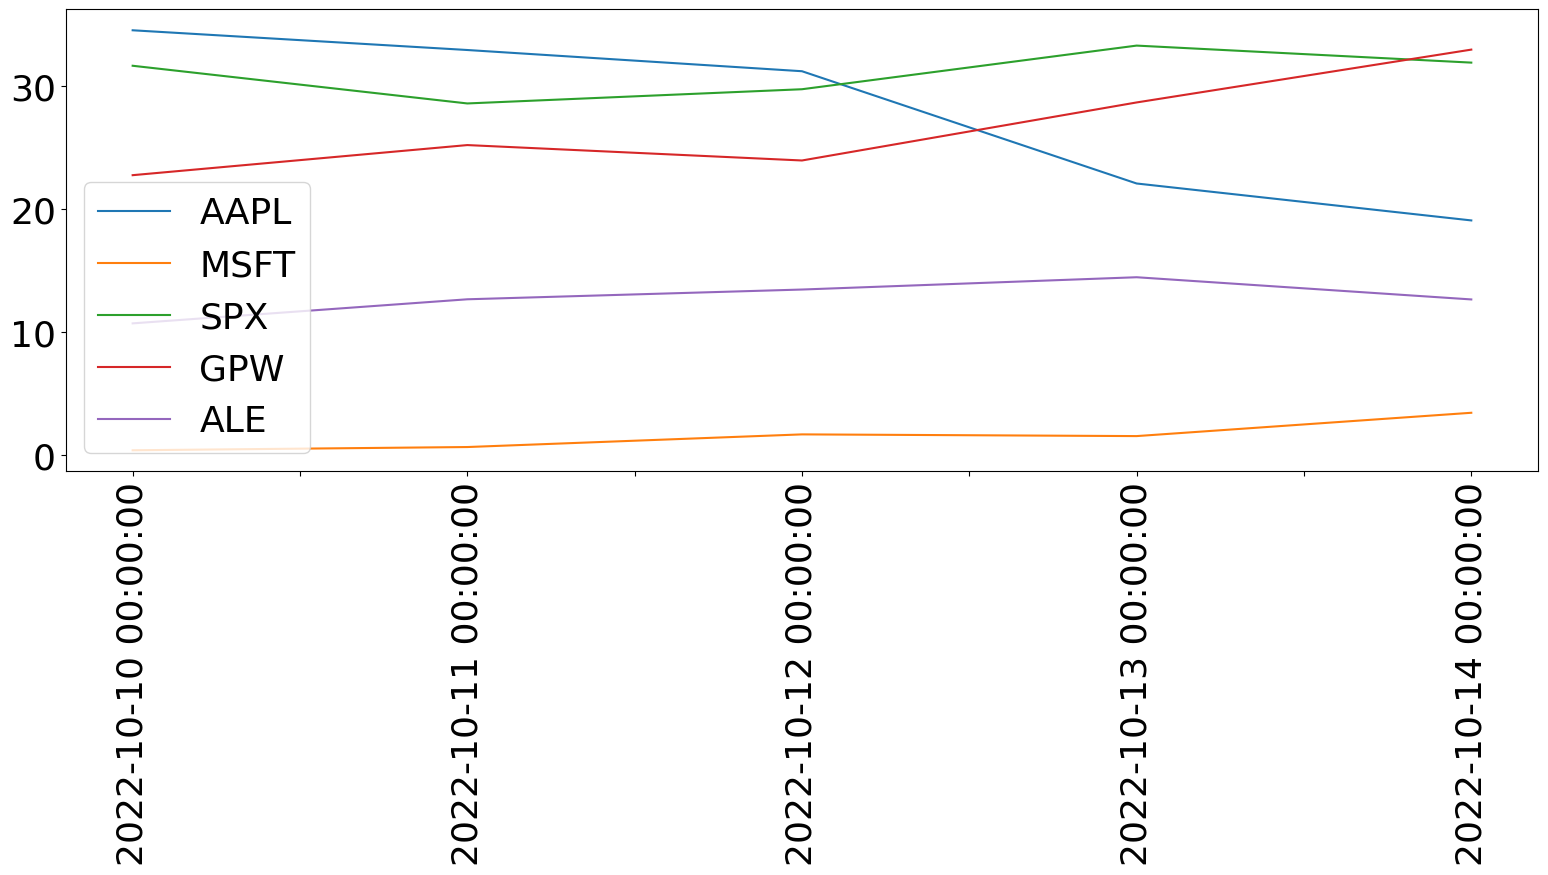

In [64]:
var_contribs_over_time = pd.DataFrame(plot_data, index=[k[0] for k in var_contribs.keys()])
#var_contribs_over_time=var_contribs_over_time.join(spx_supplement, how='left')
#var_contribs_over_time=var_contribs_over_time.join(aapl_supplement, how='left')
#var_contribs_over_time=var_contribs_over_time.join(msft_supplement, how='left')
var_contribs_over_time.plot(figsize=(19,6), rot=90)